In [325]:
#Import packages

import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn.preprocessing as prep
import sklearn.impute as imp
import sklearn.covariance as cov
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import datetime as dt


'''This has to be installed to run Self-Organizing Maps section'''
# install sompy (use our forked version - the original one has visualization bugs)
#!conda install git
#!pip install -U git+https://github.com/joaopfonseca/SOMPY.git
# IF THIS IT TAKING TOO LONG, TRY TO INSTALL IT FROM THE ANACONDA PROMPT
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView


%matplotlib inline
%config InlineBackend.figure_format = 'retina' #better quality of visualisations

import warnings
warnings.filterwarnings('ignore')
import logging 
logging.getLogger('matplotlib.font_manager').disable = True

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
# Import order product dataset
path = '/Users/rui.soromenho/Downloads/business-cases-master 2/BC3_market_basket_analysis/'
df = pd.read_csv(path+'order_products.csv', usecols=['order_id', 'product_id'])
df.head()

products = pd.read_csv(path+'products.csv')

departments = pd.read_csv(path+'departments.csv')

orders = pd.read_csv(path+'orders.csv')

#Merge all info into single dataframe
df_merged = pd.read_csv(path+'order_products.csv')
df_merged = pd.merge(df_merged, orders, how='left', on='order_id')
df_merged = pd.merge(df_merged, products, how='left', on='product_id')
df_merged = pd.merge(df_merged, departments, how='left', on='department_id')
df_merged

order_id  product_id  add_to_cart_order  reordered  user_id  \
0              10          24                  1          1   135442   
1              10          83                  2          1   135442   
2              10          16                  3          0   135442   
3              10          24                  4          1   135442   
4              10          83                  5          1   135442   
...           ...         ...                ...        ...      ...   
2019496   3420578          66                 17          0     6586   
2019497   3420578          16                 18          1     6586   
2019498   3420693          37                  1          0    68287   
2019499   3420693          37                  2          0    68287   
2019500   3420693          37                  3          0    68287   

         order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0                   4          6                  8                     8.0   
1                   4          6                  8                     8.0   
2                   4          6                  8                     8.0   
3                   4          6                  8                     8.0   
4                   4          6                  8                     8.0   
...               ...        ...                ...                     ...   
2019496             6          5                 21                     5.0   
2019497             6          5                 21                     5.0   
2019498            15          6                 15                     6.0   
2019499            15          6                 15                     6.0   
2019500            15          6                 15                     6.0   

         department_id      product_name     department  
0                    4      fresh fruits        produce  
1                    4  fresh vegetables        produce  
2                    4       fresh herbs        produce  
3                    4      fresh fruits        produce  
4                    4  fresh vegetables        produce  
...                ...               ...            ...  
2019496              6       asian foods  international  
2019497              4       fresh herbs        produce  
2019498              1     ice cream ice         frozen  
2019499              1     ice cream ice         frozen  
2019500              1     ice cream ice         frozen  

[2019501 rows x 12 columns]

## Creating a dataset grouped by user_id with clustering features

In [102]:
user_clustering_df = pd.crosstab(df_merged['user_id'], df_merged['department'])
user_clustering_df

department  alcohol  babies  bakery  beverages  breakfast  bulk  canned goods  \
user_id                                                                         
2                 0       0       0          0          0     0             0   
3                 0       0       0          1          0     0             0   
7                 0       0       1          7          0     0             2   
10                0       0       0          0          0     0             0   
11                0       0       0          3          0     0             0   
...             ...     ...     ...        ...        ...   ...           ...   
206204            0       0       1          0          0     0             0   
206205            0       0       1          1          0     0             0   
206206            0       0       0          2          0     0             0   
206208            0       0       2          1          1     0             0   
206209            0       0       2          3          1     0             1   

department  dairy eggs  deli  dry goods pasta  ...  household  international  \
user_id                                        ...                             
2                    2     3                0  ...          0              0   
3                    5     0                0  ...          1              0   
7                    4     3                0  ...          0              0   
10                   5     4                0  ...          0              0   
11                   2     0                0  ...          0              0   
...                ...   ...              ...  ...        ...            ...   
206204               6     0                2  ...          0              0   
206205               2     0                0  ...          0              0   
206206               1     1                0  ...          0              1   
206208               7     1                0  ...          0              0   
206209               4     1                0  ...          4              0   

department  meat seafood  missing  other  pantry  personal care  pets  \
user_id                                                                 
2                      0        0      0       0              0     0   
3                      0        0      0       1              0     0   
7                      1        0      0       0              0     0   
10                     4        0      0       4              0     0   
11                     0        0      0       4              0     0   
...                  ...      ...    ...     ...            ...   ...   
206204                 1        0      0       0              0     1   
206205                 0        0      0       0              0     0   
206206                 1        0      0       0              0     0   
206208                 0        0      0       0              0     0   
206209                 0        0      0       1              0     0   

department  produce  snacks  
user_id                      
2                 3       3  
3                 6       3  
7                 2       3  
10               13       0  
11                2       0  
...             ...     ...  
206204            4       0  
206205            3       0  
206206            1       4  
206208           10       2  
206209            4       2  

[105273 rows x 21 columns]

In [274]:
'''create columns with:
--total number of orders
--purchasing frequency
--total number of products
--avg reorder rate
--avg basket size
'''
#number of products ordered per user
user_product_count = df_merged.groupby('user_id')['product_id'].count()

#number of orders per user
user_order_count = df_merged.drop_duplicates('order_id').groupby('user_id')['order_number'].max()

#purchasing frequency
user_purchase_freq = df_merged.groupby('user_id')['days_since_prior_order'].mean()

#reorder rate
user_reordered_rate = df_merged.groupby('user_id')['reordered'].mean()

#basket size
user_basket_size = user_product_count/df_merged.drop_duplicates('order_id').groupby('user_id')['order_id'].count()

user_clustering_df['total_products'] = user_product_count
user_clustering_df['total_orders'] = user_order_count
user_clustering_df['time_between_purchases'] = user_purchase_freq
user_clustering_df['reorder_rate'] = user_reordered_rate
user_clustering_df['basket_size'] = user_basket_size

## Separate data into 'behavior' and 'product preferences'

In [275]:
#df for analyzing purchasing behavior
user_clustering_df_behavior = user_clustering_df.iloc[:,-5:]

#df for analyzing product preferences
user_clustering_df_product = user_clustering_df.iloc[:,:-5]
user_clustering_df_product['sum'] = user_clustering_df_product.sum(axis=1)

for column in user_clustering_df.iloc[:,:-5].columns:
    user_clustering_df_product[column] = round((user_clustering_df_product[column]/user_clustering_df_product['sum'])*100, 2)
    
user_clustering_df_product = user_clustering_df_product.iloc[:,:-1]

#df combining bith behavior and product preferences
user_clustering_df_combined = pd.concat([user_clustering_df_product, user_clustering_df_behavior], axis=1)

## Clustering by 'behavior'

In [276]:
#Applying StandardScaler to metric variables
data_to_scale = user_clustering_df_behavior.fillna(data_test['time_between_purchases'].mean()).copy()

scaler = StandardScaler()
metric_features_scaled = scaler.fit_transform(data_to_scale)
data_scaled = pd.DataFrame(metric_features_scaled, 
                           columns=data_to_scale.columns)
data_scaled

department  total_products  total_orders  time_between_purchases  \
0                -0.409503     -0.746013               -0.714760   
1                -0.009181     -0.290343               -0.083100   
2                 0.241021     -0.746013                1.898727   
3                 0.541263     -0.689054                0.094908   
4                -0.409503     -0.632096                1.898727   
...                    ...           ...                     ...   
105268            0.040860     -0.802972               -0.243308   
105269           -0.609665     -0.746013               -0.356046   
105270           -0.209342      2.044969               -1.182797   
105271            0.341102      1.817134               -0.451441   
105272            0.241021     -0.347301                1.025002   

department  reorder_rate  basket_size  
0              -0.555680    -0.651245  
1              -0.201909    -0.532861  
2               0.954256     1.976873  
3              -0.331625     2.829236  
4              -0.847926     0.130087  
...                  ...          ...  
105268         -1.081722     1.408631  
105269          1.030797    -0.438154  
105270          0.632786    -0.899851  
105271          1.242755     0.414208  
105272         -0.117311    -0.296094  

[105273 rows x 5 columns]

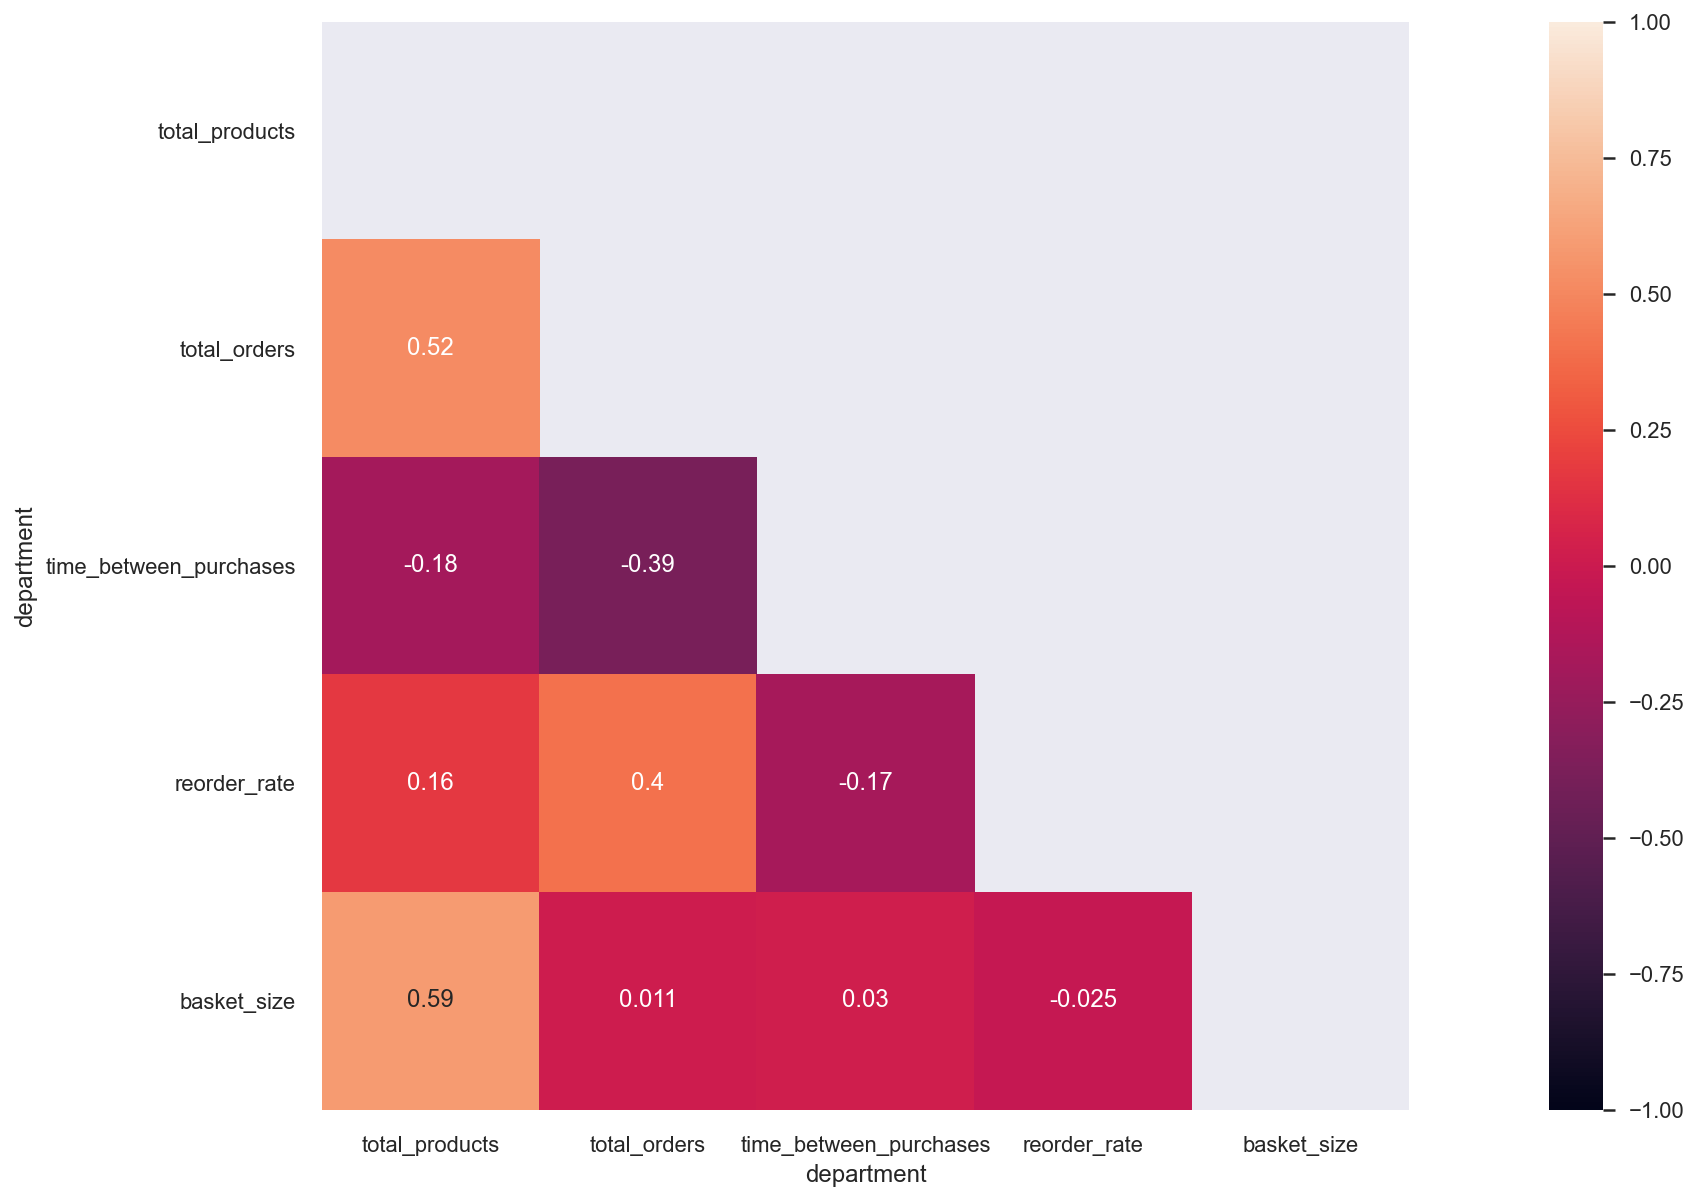

In [277]:
#Plot correlation matrix
data_test = data_scaled

fig, axes = plt.subplots(1, 1, figsize=(25, 10))

mask = np.zeros_like(data_test.corr(method="pearson"), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(data_test.corr(method="pearson"),vmin=-1, vmax=1, square=True, annot=True, mask=mask)

plt.show()

In [278]:
df_pca = data_test

# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(df_pca)
pca_feat

array([[-7.99698532e-01, -4.48388715e-01, -9.12829719e-01,
        -3.36348851e-01,  4.25502761e-01],
       [-3.77441925e-01, -2.43575407e-01, -2.12102812e-01,
         1.04141023e-01,  3.97960827e-01],
       [-5.11381986e-04,  2.02223787e+00,  2.04182554e+00,
        -7.49349177e-01, -4.67333748e-01],
       ...,
       [ 1.39604915e+00, -1.97920109e+00, -3.88299095e-01,
         6.56232463e-01, -6.22312060e-01],
       [ 1.95211289e+00, -7.54591464e-01,  5.72188679e-01,
         1.72664031e-01, -7.75091922e-01],
       [-5.59438154e-01,  4.17173158e-01,  6.37337576e-01,
         5.10563709e-01,  4.20587131e-01]])

In [279]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1    2.042106    0.000000    0.408417    0.408417
2    1.348437   -0.693669    0.269685    0.678102
3    0.825418   -0.523019    0.165082    0.843184
4    0.571796   -0.253621    0.114358    0.957542
5    0.212290   -0.359506    0.042458    1.000000

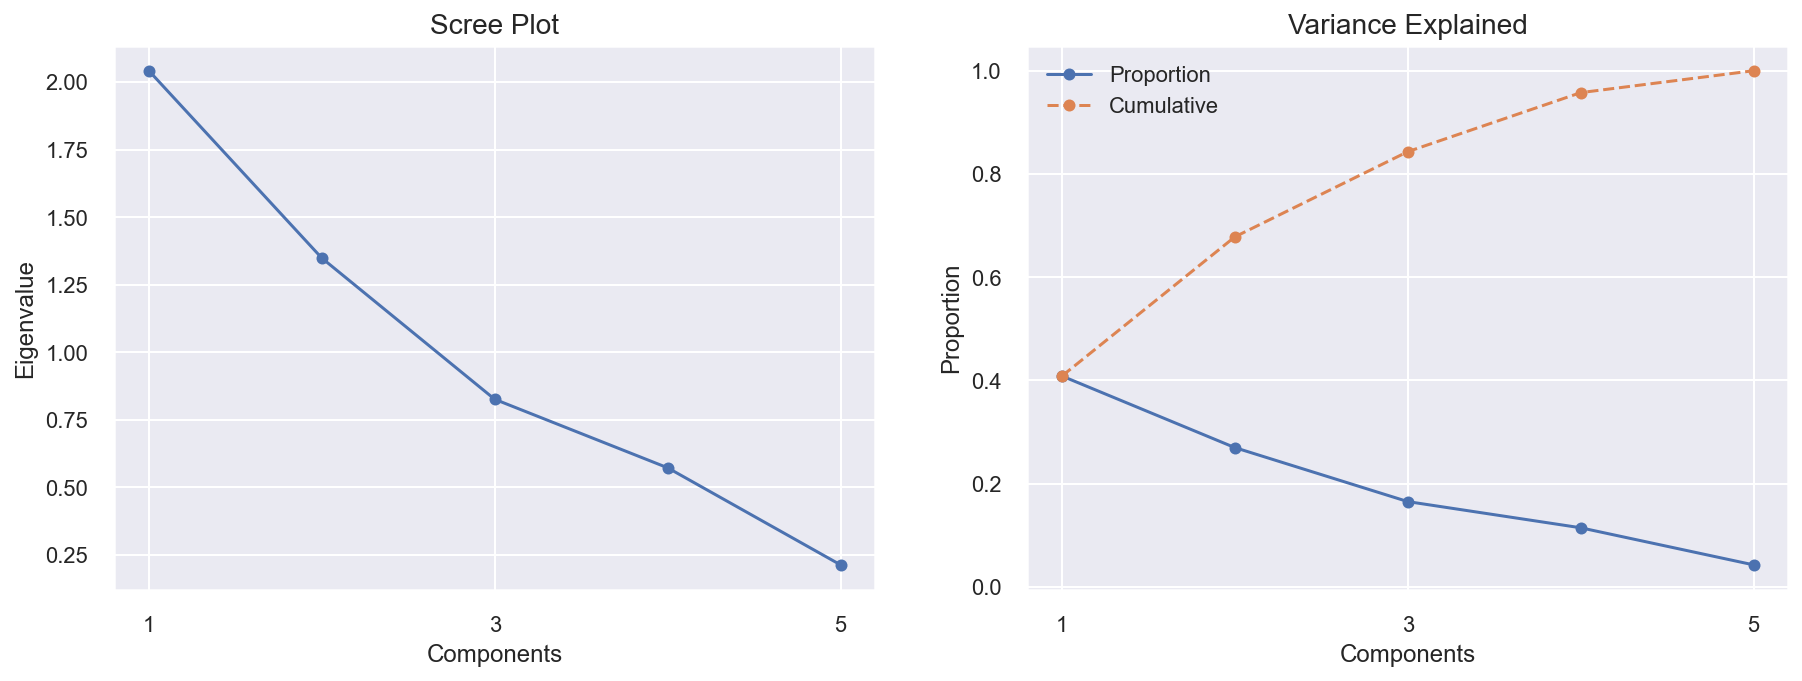

In [280]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [281]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(df_pca)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

PC0       PC1       PC2
0      -0.799699 -0.448389 -0.912830
1      -0.377442 -0.243575 -0.212103
2      -0.000511  2.022238  2.041826
3       0.657795  2.530157 -0.134973
4      -1.535438  1.161771  0.758614
...          ...       ...       ...
105268 -0.285995  1.550786 -0.919443
105269 -0.407593 -0.857319  0.460456
105270  1.396049 -1.979201 -0.388299
105271  1.952113 -0.754591  0.572189
105272 -0.559438  0.417173  0.637338

[105273 rows x 3 columns]

In [282]:
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

total_products  total_orders  time_between_purchases  reorder_rate  \
0       -0.409503     -0.746013               -0.714760     -0.555680   
1       -0.009181     -0.290343               -0.083100     -0.201909   
2        0.241021     -0.746013                1.898727      0.954256   
3        0.541263     -0.689054                0.094908     -0.331625   
4       -0.409503     -0.632096                1.898727     -0.847926   

   basket_size       PC0       PC1       PC2  
0    -0.651245 -0.799699 -0.448389 -0.912830  
1    -0.532861 -0.377442 -0.243575 -0.212103  
2     1.976873 -0.000511  2.022238  2.041826  
3     2.829236  0.657795  2.530157 -0.134973  
4     0.130087 -1.535438  1.161771  0.758614

In [283]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca.corr()[pca_feat_names].loc[data_test.columns]
loadings.style.applymap(_color_red_or_green)

In [114]:
def get_r2_hc(df, link, max_nclus, min_nclus=1, dist="euclidean"):
    """
    This function calculates the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on the fact that the Sum of squares (SSt) of all the data
    can be decomposed into the sum of SS within clusters (SSw) and SS between clusters (SSb): SSt = SSw + SSb. The R2 is the ratio between
    SSb and SSt: R2 = SSb/SSt. The higher the R2 the better the solution since SSw will be close to 0 which indicated perfect homogeneous
    clusters.
    """
    def get_ss(matrix):
        mc = matrix - matrix.mean(axis=0)
        return (mc.T@mc).trace() #return sum of squares of matrix
    
    matrix = df.values
    ncols = matrix.shape[1]
    sst = get_ss(matrix) #get total sum of squares
    
    r2 = np.array([]) #where we will store the R2 metrics
    
    for i in range(min_nclus, max_nclus+1):
        Hclustering = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link)
        hclabels = Hclustering.fit_predict(matrix) #get cluster labels
        concat = np.concatenate((matrix, np.expand_dims(hclabels,1)), axis=1)
        ssw = np.array([get_ss(concat[concat[:,ncols]==j, :ncols]) for j in range(i)]).sum() #calculate ssw for a given cluster solution
        r2 = np.append(r2, (sst-ssw)/sst) #save the R2 of the given cluster solution
        
    return r2

In [116]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(s=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [289]:
#Define data for clustering 
data_clust_test = data_test.fillna(data_test['time_between_purchases'].mean())
data_clust_test

department  total_products  total_orders  time_between_purchases  \
0                -0.409503     -0.746013               -0.714760   
1                -0.009181     -0.290343               -0.083100   
2                 0.241021     -0.746013                1.898727   
3                 0.541263     -0.689054                0.094908   
4                -0.409503     -0.632096                1.898727   
...                    ...           ...                     ...   
105268            0.040860     -0.802972               -0.243308   
105269           -0.609665     -0.746013               -0.356046   
105270           -0.209342      2.044969               -1.182797   
105271            0.341102      1.817134               -0.451441   
105272            0.241021     -0.347301                1.025002   

department  reorder_rate  basket_size  
0              -0.555680    -0.651245  
1              -0.201909    -0.532861  
2               0.954256     1.976873  
3              -0.331625     2.829236  
4              -0.847926     0.130087  
...                  ...          ...  
105268         -1.081722     1.408631  
105269          1.030797    -0.438154  
105270          0.632786    -0.899851  
105271          1.242755     0.414208  
105272         -0.117311    -0.296094  

[105273 rows x 5 columns]

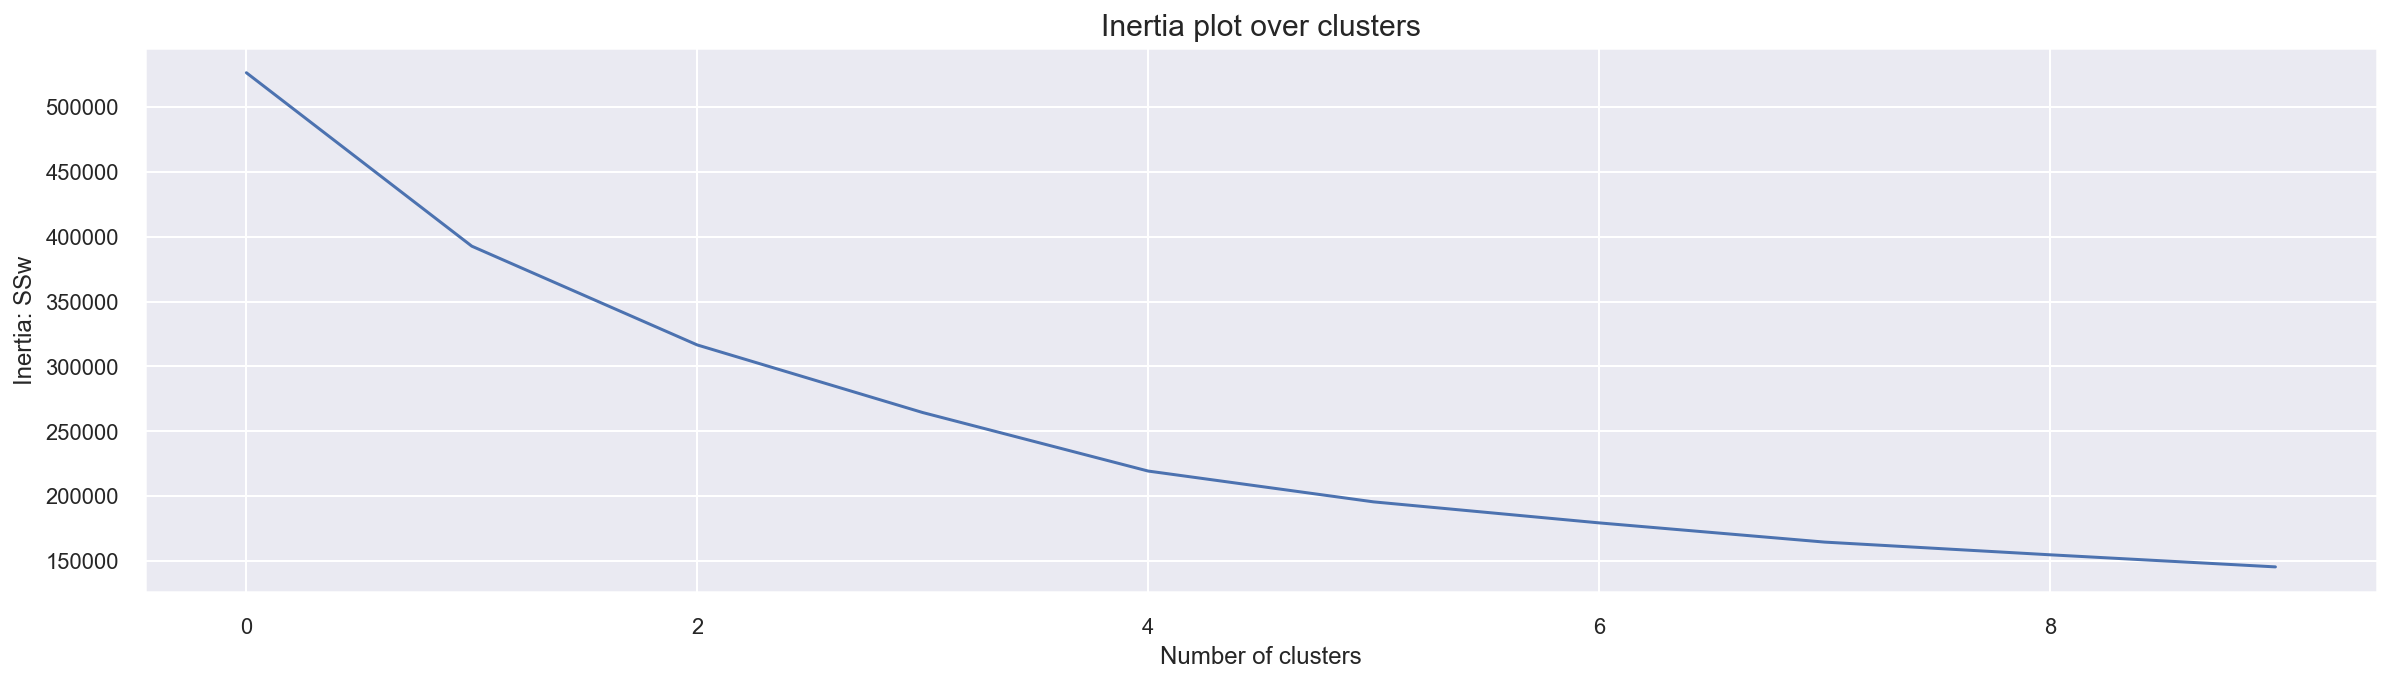

In [290]:
range_clusters = range(1, 11)
inertia = []

for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(data_clust_test)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

# The inertia plot
plt.figure(figsize=(20,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [291]:
#K means Clustering 
def doKmeans(df, nclust):
    model = KMeans(nclust, random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    cent = model.cluster_centers_
    return (clust_labels, cent)

In [292]:
# Performing kmeans and appending the cluster labels to a new dataframe that keeps the cluster labels
clust_labels, cent = doKmeans(data_clust_test, 4)
kmeans_data_clust_test = data_clust_test.copy()
kmeans_data_clust_test["kmeans_labels"] = clust_labels

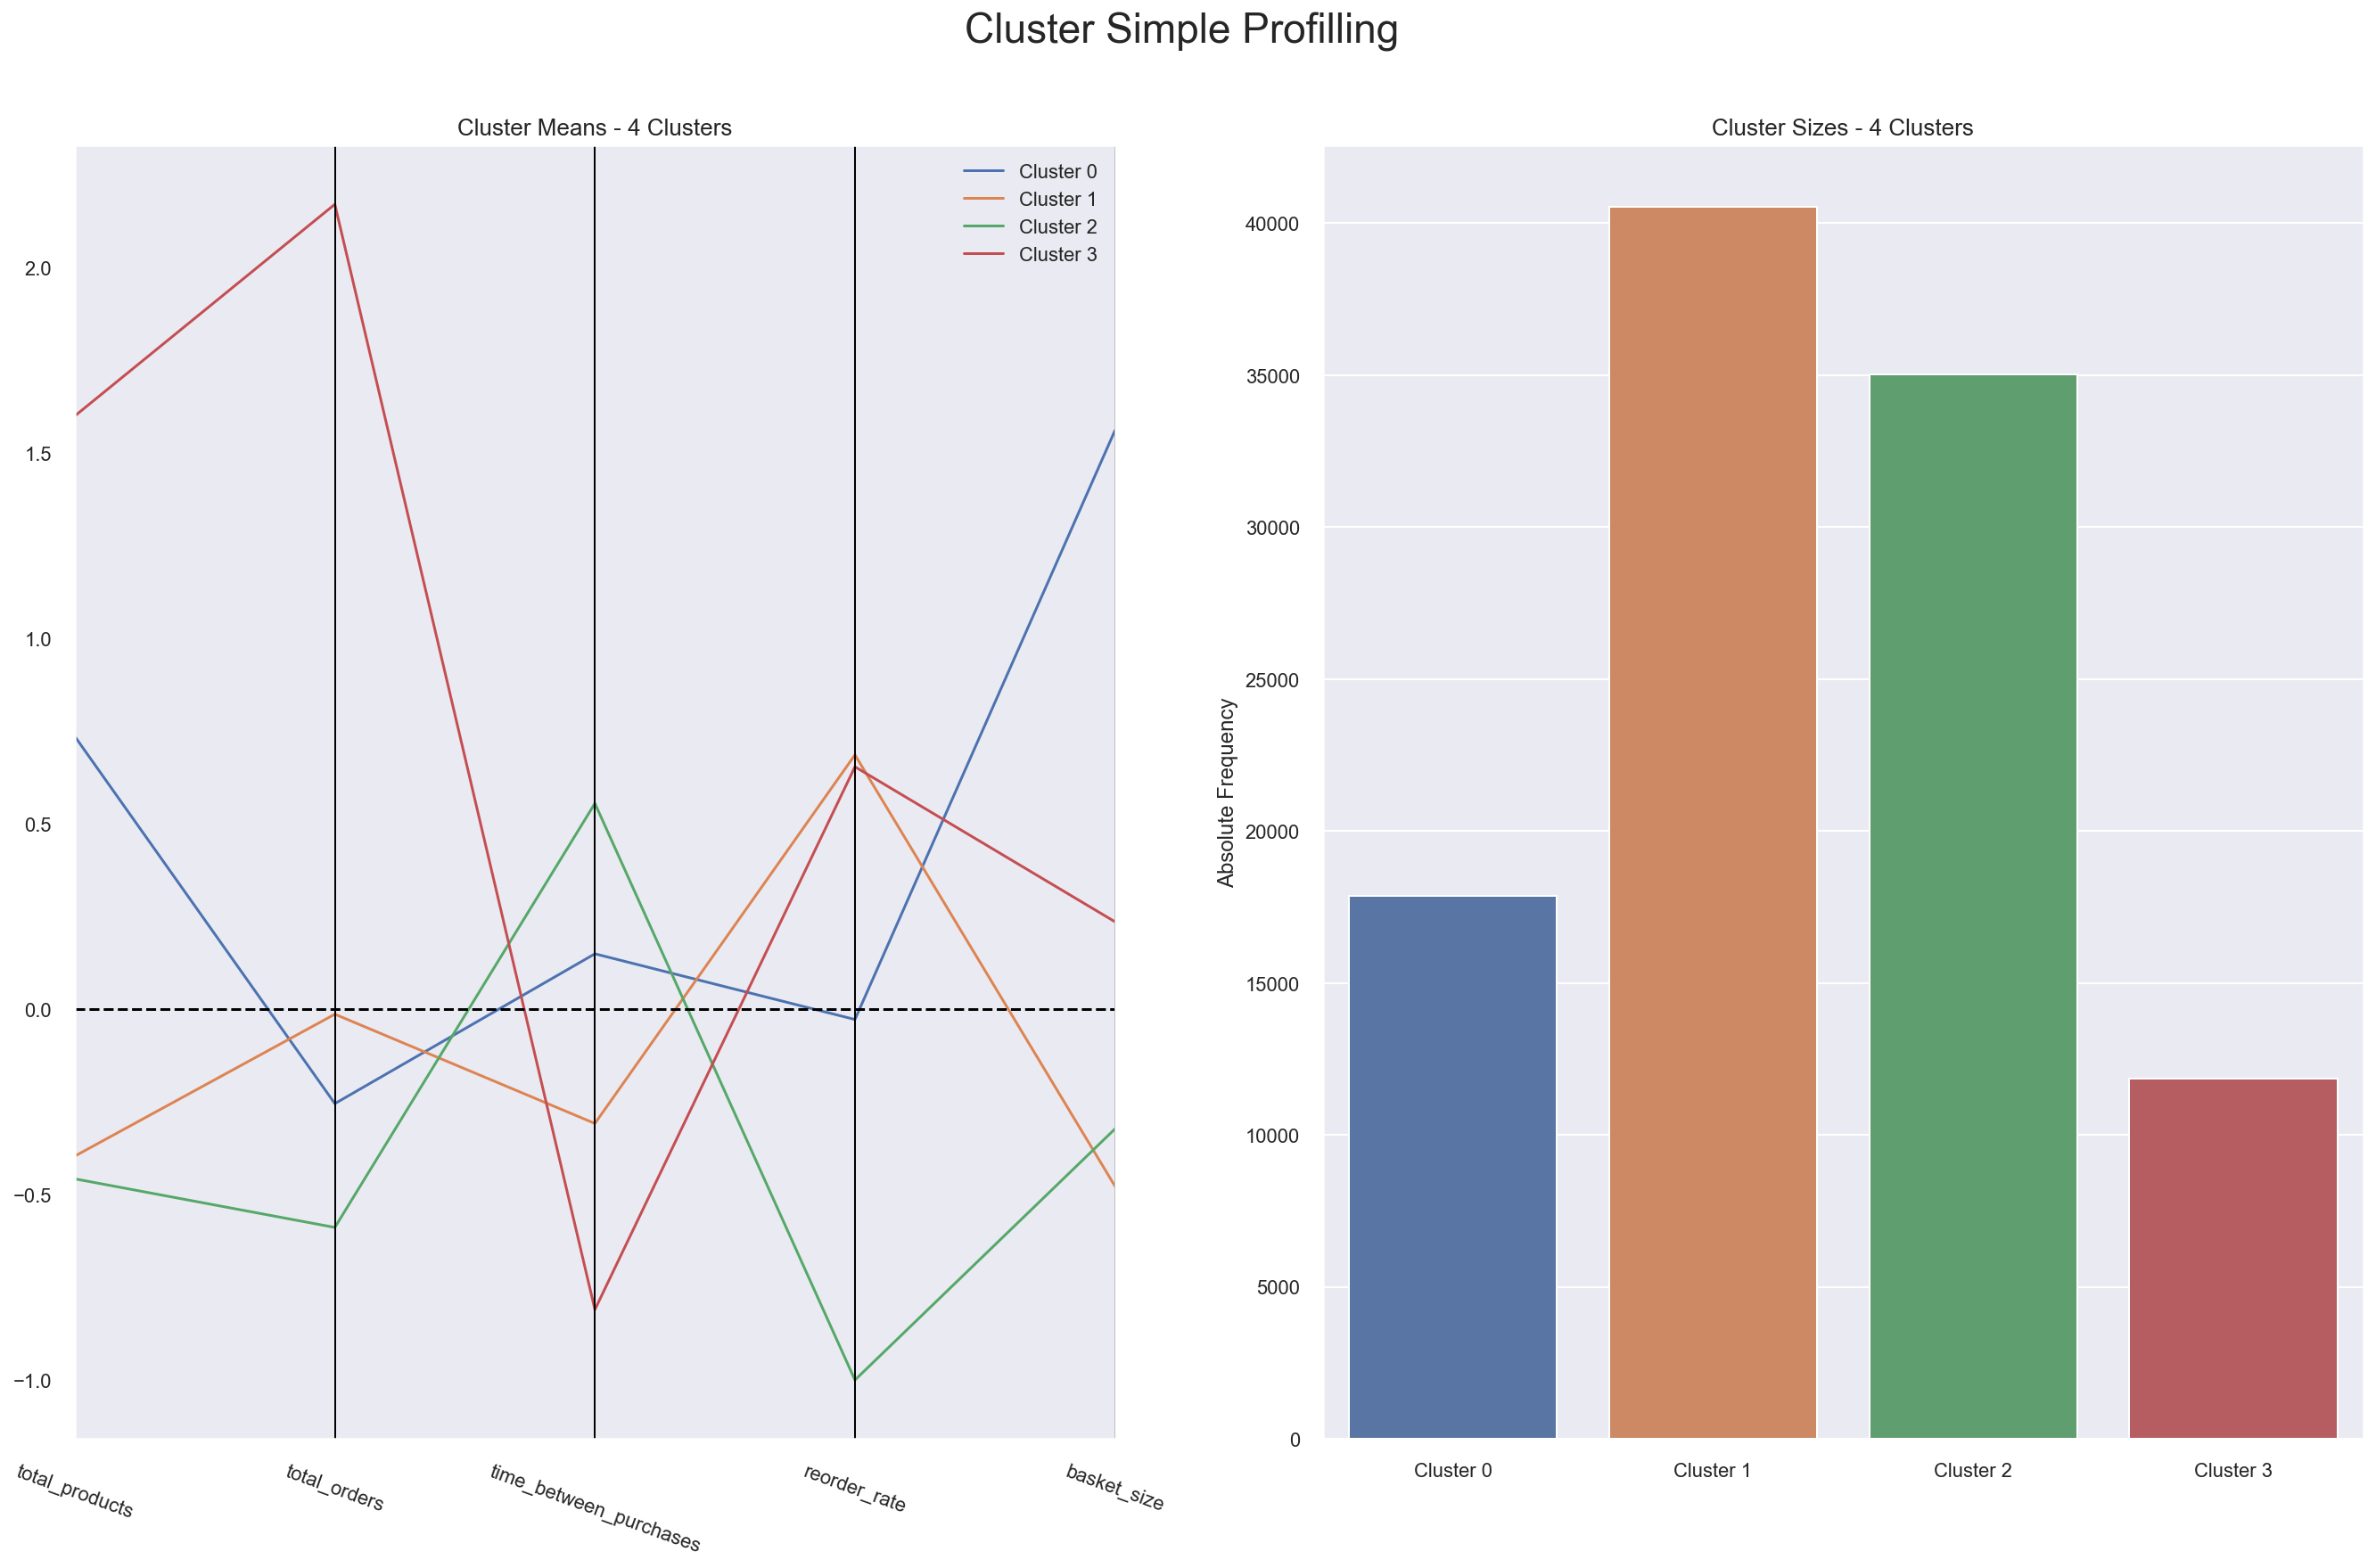

In [293]:
cluster_profiles(kmeans_data_clust_test, ["kmeans_labels"], figsize=(23, 13))

In [294]:
kmeans_summary = user_clustering_df_behavior.copy()
kmeans_summary['kmeans_labels'] = kmeans_data_clust_test['kmeans_labels'].reset_index().set_index(user_clustering_df_behavior.index).drop(columns='index')['kmeans_labels']
round(kmeans_summary.groupby("kmeans_labels").mean(), 2)

department     total_products  total_orders  time_between_purchases  \
kmeans_labels                                                         
0                       33.88         11.62                   14.53   
1                       11.26         15.86                   10.42   
2                       10.04          5.76                   19.03   
3                       51.15         54.21                    5.97   

department     reorder_rate  basket_size  
kmeans_labels                             
0                      0.53        21.07  
1                      0.75         6.72  
2                      0.23         7.81  
3                      0.74        11.74

In [295]:
sums = kmeans_summary.groupby("kmeans_labels").sum()[['total_products', 
                                               'total_orders']].rename(columns={'total_products': 'sum_total_products',
                                                                               'total_orders': 'sum_total_orders'})
#summary = pd.concat([kmeans_summary.groupby("kmeans_labels").mean(), sums], axis=1)
#summary.iloc[:, :-7].apply(lambda x: (x / x.sum())*100,axis=1)

In [296]:
summary = pd.concat([kmeans_summary.groupby("kmeans_labels").mean(), sums], axis=1)
round(summary.T, 2)

kmeans_labels                   0          1          2          3
department                                                        
total_products              33.88      11.26      10.04      51.15
total_orders                11.62      15.86       5.76      54.21
time_between_purchases      14.53      10.42      19.03       5.97
reorder_rate                 0.53       0.75       0.23       0.74
basket_size                 21.07       6.72       7.81      11.74
sum_total_products      605139.00  456378.00  351570.00  606414.00
sum_total_orders        207596.00  642620.00  201800.00  642607.00

## Clustering by 'product preferences'

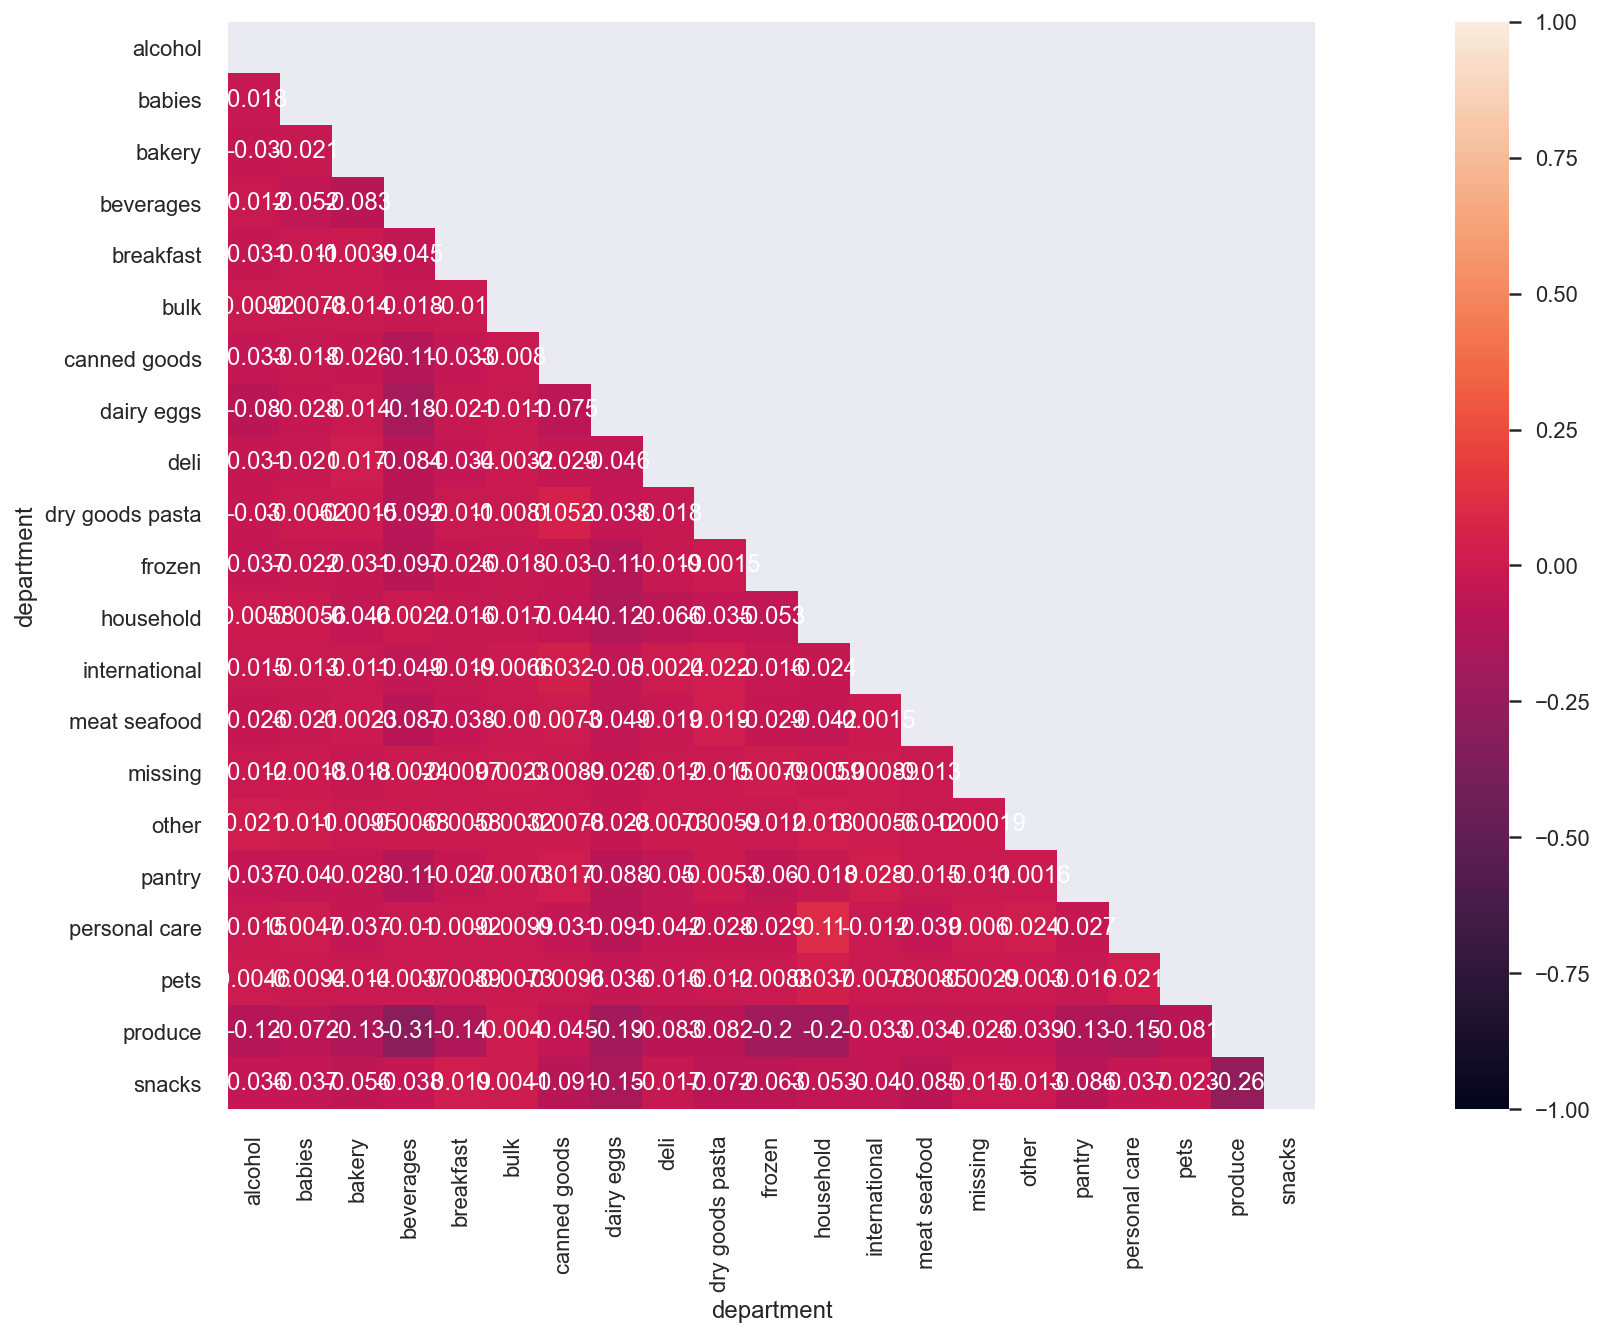

In [171]:
#Plot correlation matrix
data_test = user_clustering_df_product

fig, axes = plt.subplots(1, 1, figsize=(25, 10))

mask = np.zeros_like(data_test.corr(method="pearson"), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(data_test.corr(method="pearson"),vmin=-1, vmax=1, square=True, annot=True, mask=mask)

plt.show()

In [202]:
#Applying StandardScaler to metric variables
data_to_scale = user_clustering_df_product.copy()

scaler = StandardScaler()
metric_features_scaled = scaler.fit_transform(data_to_scale)
data_scaled = pd.DataFrame(metric_features_scaled, 
                           columns=data_to_scale.columns)
data_scaled

department   alcohol    babies    bakery  beverages  breakfast      bulk  \
0          -0.129483 -0.184594 -0.485675  -0.612484  -0.355800 -0.078516   
1          -0.129483 -0.184594 -0.485675  -0.295520  -0.355800 -0.078516   
2          -0.129483 -0.184594  0.092363   1.145278  -0.355800 -0.078516   
3          -0.129483 -0.184594 -0.485675  -0.612484  -0.355800 -0.078516   
4          -0.129483 -0.184594 -0.485675   1.030785  -0.355800 -0.078516   
...              ...       ...       ...        ...        ...       ...   
105268     -0.129483 -0.184594  0.207416  -0.612484  -0.355800 -0.078516   
105269     -0.129483 -0.184594  1.495178   0.248621  -0.355800 -0.078516   
105270     -0.129483 -0.184594 -0.485675   0.190772  -0.355800 -0.078516   
105271     -0.129483 -0.184594  0.580299  -0.380486   0.287566 -0.078516   
105272     -0.129483 -0.184594  0.669014   0.140757   0.341040 -0.078516   

department  canned goods  dairy eggs      deli  dry goods pasta  ...  \
0              -0.442095    0.127302  3.589061        -0.416099  ...   
1              -0.442095    0.637966 -0.453969        -0.416099  ...   
2               0.819652    0.032572  1.399272        -0.416099  ...   
3              -0.442095    0.032572  1.522327        -0.416099  ...   
4              -0.442095    0.127302 -0.453969        -0.416099  ...   
...                  ...         ...       ...              ...  ...   
105268         -0.442095    0.868831 -0.453969         1.364885  ...   
105269         -0.442095    0.779120 -0.453969        -0.416099  ...   
105270         -0.442095   -0.594778  0.534920        -0.416099  ...   
105271         -0.442095    0.675607  0.116829        -0.416099  ...   
105272          0.189536    0.032572  0.164272        -0.416099  ...   

department  household  international  meat seafood   missing     other  \
0           -0.315404      -0.238583     -0.374137 -0.125619 -0.083975   
1            0.266478      -0.238583     -0.374137 -0.125619 -0.083975   
2           -0.315404      -0.238583      0.332679 -0.125619 -0.083975   
3           -0.315404      -0.238583      1.885302 -0.125619 -0.083975   
4           -0.315404      -0.238583     -0.374137 -0.125619 -0.083975   
...               ...            ...           ...       ...       ...   
105268      -0.315404      -0.238583      0.473364 -0.125619 -0.083975   
105269      -0.315404      -0.238583     -0.374137 -0.125619 -0.083975   
105270      -0.315404       1.859922      0.756430 -0.125619 -0.083975   
105271      -0.315404      -0.238583     -0.374137 -0.125619 -0.083975   
105272       1.528698      -0.238583     -0.374137 -0.125619 -0.083975   

department    pantry  personal care      pets   produce    snacks  
0          -0.582982      -0.258857 -0.108467 -0.034584  1.308315  
1          -0.046874      -0.258857 -0.108467  0.151010  0.489132  
2          -0.582982      -0.258857 -0.108467 -0.850162  0.254367  
3           0.775634      -0.258857 -0.108467  0.656979 -0.637601  
4           3.122889      -0.258857 -0.108467 -0.426009 -0.637601  
...              ...            ...       ...       ...       ...  
105268     -0.582982      -0.258857  1.490523 -0.347638 -0.637601  
105269     -0.582982      -0.258857 -0.108467  0.636740 -0.637601  
105270     -0.582982      -0.258857 -0.108467 -0.921643  1.265501  
105271     -0.582982      -0.258857 -0.108467  0.447271 -0.088862  
105272     -0.157969      -0.258857 -0.108467 -0.491032 -0.043194  

[105273 rows x 21 columns]

In [203]:
df_pca = data_scaled.dropna().copy()

# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(df_pca)
pca_feat

array([[-1.38258940e-01, -2.66079097e-01, -1.75052243e+00, ...,
         2.59691002e-01, -2.27763008e-01, -2.11460731e-04],
       [-1.42650360e-02,  1.85424436e-01, -6.30650929e-01, ...,
         7.57858481e-03, -4.08801276e-01,  1.34395595e-05],
       [ 6.54843305e-01, -2.26410488e-01, -6.36622948e-01, ...,
        -8.75018844e-01, -5.80626287e-02,  2.42905410e-04],
       ...,
       [ 9.39142147e-01, -4.68149448e-01, -8.45295281e-02, ...,
        -5.47982955e-01, -2.50548874e-01,  4.71041797e-04],
       [-5.55859752e-01, -2.83943382e-01, -1.11328487e+00, ...,
        -1.15880752e-01, -6.96458170e-02,  1.46211131e-05],
       [ 8.22772480e-01, -1.23796248e-01,  1.28416968e-02, ...,
        -3.03335519e-01, -1.29241808e+00,  4.68603632e-04]])

In [204]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference    Proportion  Cumulative
1   1.532939e+00    0.000000  7.299639e-02    0.072996
2   1.237942e+00   -0.294996  5.894908e-02    0.131945
3   1.226175e+00   -0.011767  5.838874e-02    0.190334
4   1.138686e+00   -0.087489  5.422263e-02    0.244557
5   1.076734e+00   -0.061953  5.127254e-02    0.295829
6   1.064419e+00   -0.012314  5.068615e-02    0.346516
7   1.046039e+00   -0.018380  4.981091e-02    0.396326
8   1.026736e+00   -0.019302  4.889175e-02    0.445218
9   1.021227e+00   -0.005510  4.862937e-02    0.493848
10  1.008486e+00   -0.012741  4.802267e-02    0.541870
11  1.000819e+00   -0.007667  4.765759e-02    0.589528
12  9.956016e-01   -0.005217  4.740915e-02    0.636937
13  9.835533e-01   -0.012048  4.683542e-02    0.683772
14  9.820200e-01   -0.001533  4.676241e-02    0.730535
15  9.734824e-01   -0.008538  4.635586e-02    0.776891
16  9.631494e-01   -0.010333  4.586382e-02    0.822754
17  9.618202e-01   -0.001329  4.580053e-02    0.868555
18  9.382134e-01   -0.023607  4.467640e-02    0.913231
19  9.342592e-01   -0.003954  4.448811e-02    0.957720
20  8.878983e-01   -0.046361  4.228047e-02    1.000000
21  4.855069e-08   -0.887898  2.311916e-09    1.000000

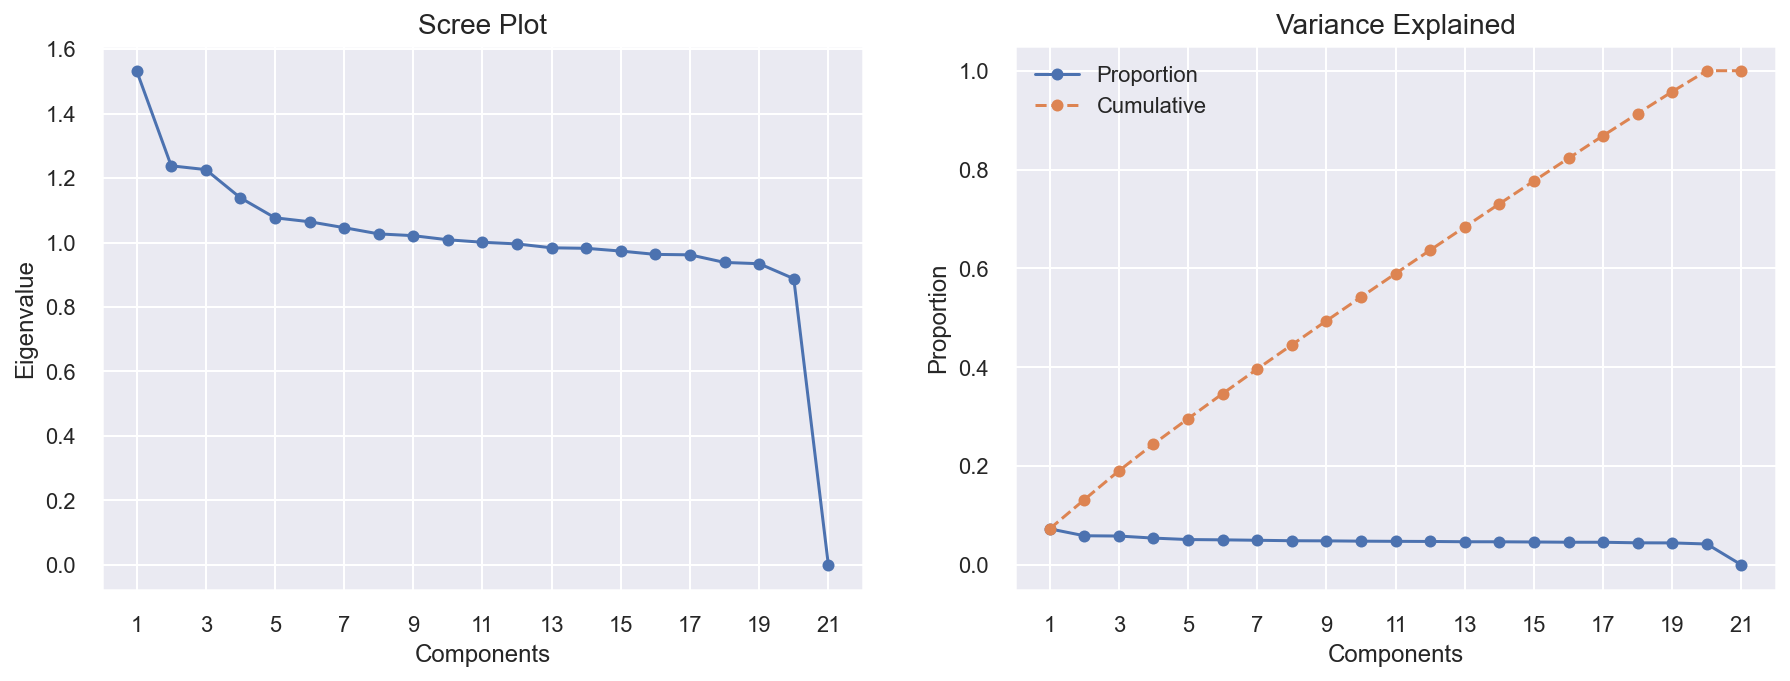

In [205]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [206]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=7)
pca_feat = pca.fit_transform(df_pca)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

PC0       PC1       PC2       PC3       PC4       PC5       PC6
0      -0.044215 -0.188390 -1.439995  1.570616 -0.181688 -0.354607  1.744391
1       0.002583 -0.337138 -0.505097 -0.236382 -0.083515  0.384842 -0.418585
2       0.682863  0.115199 -0.624974  0.617702  0.051931 -1.036196 -0.017244
3      -1.399847 -0.035294  0.203264  0.027550  0.185453 -0.944310  0.701226
4       0.315151 -0.103366  0.724483 -0.677248 -1.986488 -0.351419 -1.015699
...          ...       ...       ...       ...       ...       ...       ...
105268 -0.301807  1.477942  0.030915 -0.285637  1.533364 -0.515478 -1.061039
105269 -0.738724 -0.215195 -1.034830 -1.101249  0.068778 -0.762952  0.205745
105270  0.939800  0.462869 -0.232341  2.042869  0.848751 -0.155076 -0.184233
105271 -0.553677  0.051994 -1.148036 -0.355282  0.265929  0.025781  0.285835
105272  0.822935  0.189569 -0.036604 -0.531574 -0.333395  0.137984  0.595504

[105273 rows x 7 columns]

In [207]:
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

alcohol    babies    bakery  beverages  breakfast      bulk  canned goods  \
0 -0.129483 -0.184594 -0.485675  -0.612484    -0.3558 -0.078516     -0.442095   
1 -0.129483 -0.184594 -0.485675  -0.295520    -0.3558 -0.078516     -0.442095   
2 -0.129483 -0.184594  0.092363   1.145278    -0.3558 -0.078516      0.819652   
3 -0.129483 -0.184594 -0.485675  -0.612484    -0.3558 -0.078516     -0.442095   
4 -0.129483 -0.184594 -0.485675   1.030785    -0.3558 -0.078516     -0.442095   

   dairy eggs      deli  dry goods pasta  ...      pets   produce    snacks  \
0    0.127302  3.589061        -0.416099  ... -0.108467 -0.034584  1.308315   
1    0.637966 -0.453969        -0.416099  ... -0.108467  0.151010  0.489132   
2    0.032572  1.399272        -0.416099  ... -0.108467 -0.850162  0.254367   
3    0.032572  1.522327        -0.416099  ... -0.108467  0.656979 -0.637601   
4    0.127302 -0.453969        -0.416099  ... -0.108467 -0.426009 -0.637601   

        PC0       PC1       PC2       PC3       PC4       PC5       PC6  
0 -0.044215 -0.188390 -1.439995  1.570616 -0.181688 -0.354607  1.744391  
1  0.002583 -0.337138 -0.505097 -0.236382 -0.083515  0.384842 -0.418585  
2  0.682863  0.115199 -0.624974  0.617702  0.051931 -1.036196 -0.017244  
3 -1.399847 -0.035294  0.203264  0.027550  0.185453 -0.944310  0.701226  
4  0.315151 -0.103366  0.724483 -0.677248 -1.986488 -0.351419 -1.015699  

[5 rows x 28 columns]

In [208]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca.corr()[pca_feat_names].loc[data_test.columns]
loadings.style.applymap(_color_red_or_green)

In [209]:
#Define data for clustering 
data_clust_test = pca_df
data_clust_test

PC0       PC1       PC2       PC3       PC4       PC5       PC6
0      -0.044215 -0.188390 -1.439995  1.570616 -0.181688 -0.354607  1.744391
1       0.002583 -0.337138 -0.505097 -0.236382 -0.083515  0.384842 -0.418585
2       0.682863  0.115199 -0.624974  0.617702  0.051931 -1.036196 -0.017244
3      -1.399847 -0.035294  0.203264  0.027550  0.185453 -0.944310  0.701226
4       0.315151 -0.103366  0.724483 -0.677248 -1.986488 -0.351419 -1.015699
...          ...       ...       ...       ...       ...       ...       ...
105268 -0.301807  1.477942  0.030915 -0.285637  1.533364 -0.515478 -1.061039
105269 -0.738724 -0.215195 -1.034830 -1.101249  0.068778 -0.762952  0.205745
105270  0.939800  0.462869 -0.232341  2.042869  0.848751 -0.155076 -0.184233
105271 -0.553677  0.051994 -1.148036 -0.355282  0.265929  0.025781  0.285835
105272  0.822935  0.189569 -0.036604 -0.531574 -0.333395  0.137984  0.595504

[105273 rows x 7 columns]

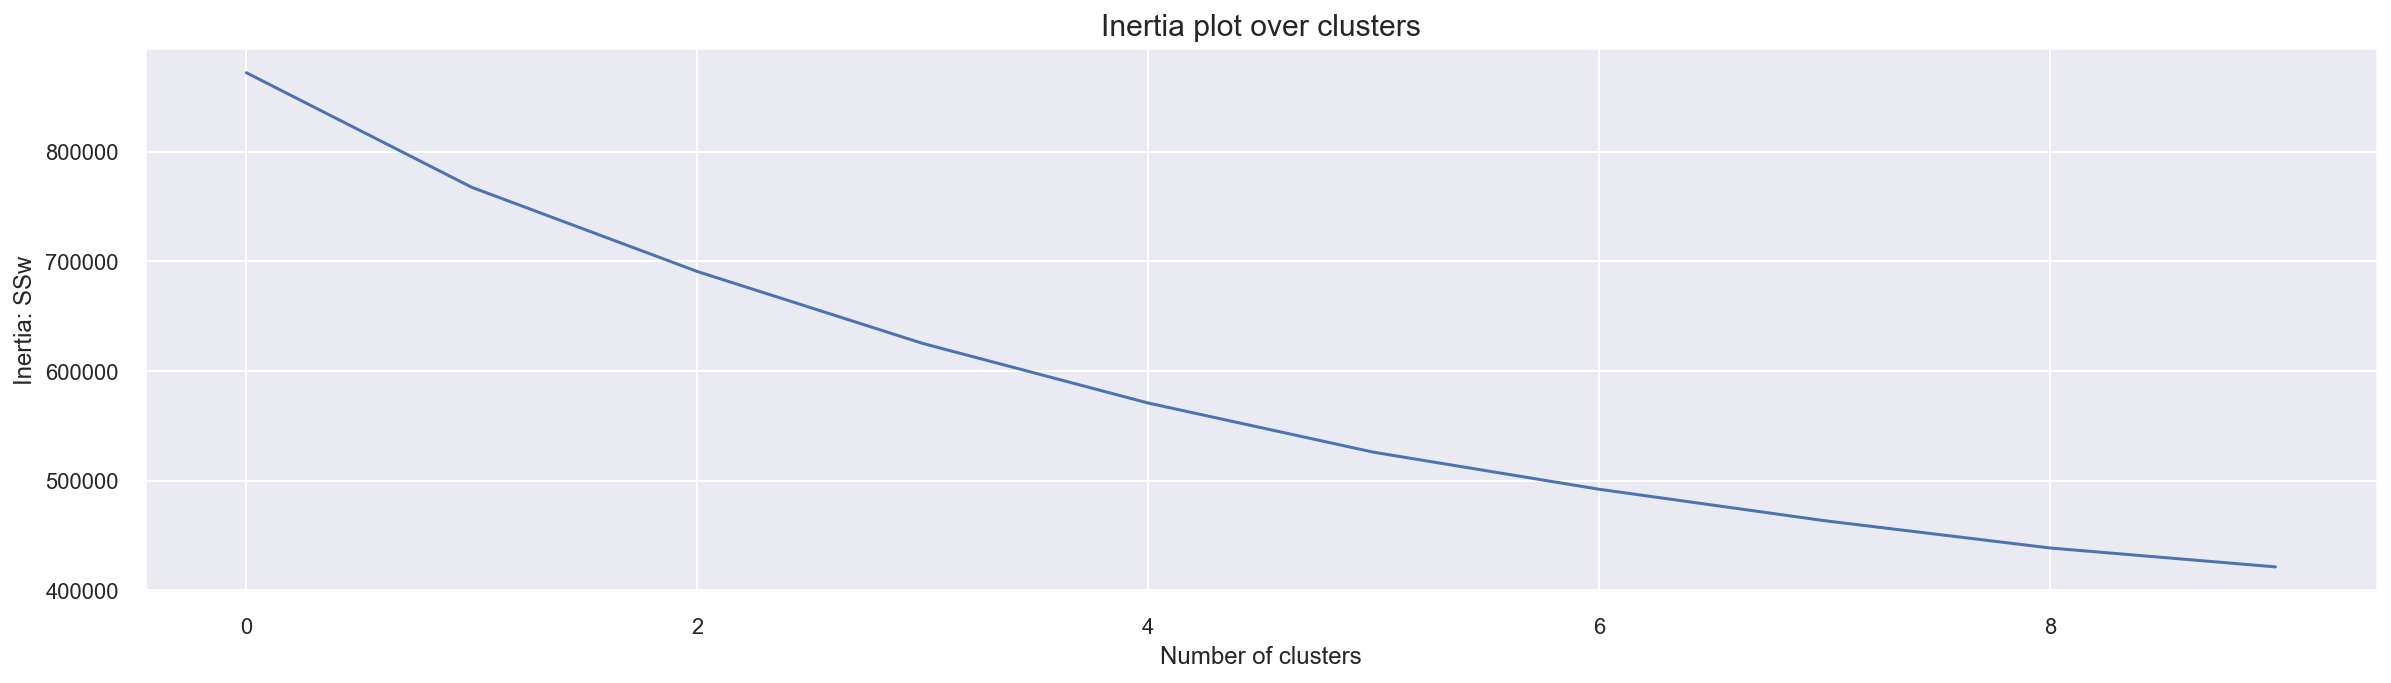

In [210]:
range_clusters = range(1, 11)
inertia = []

for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(data_clust_test)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

# The inertia plot
plt.figure(figsize=(20,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [211]:
# Performing kmeans and appending the cluster labels to a new dataframe that keeps the cluster labels
clust_labels, cent = doKmeans(data_clust_test, 4)
kmeans_data_clust_test = user_clustering_df_product.copy()
kmeans_data_clust_test["kmeans_labels"] = clust_labels

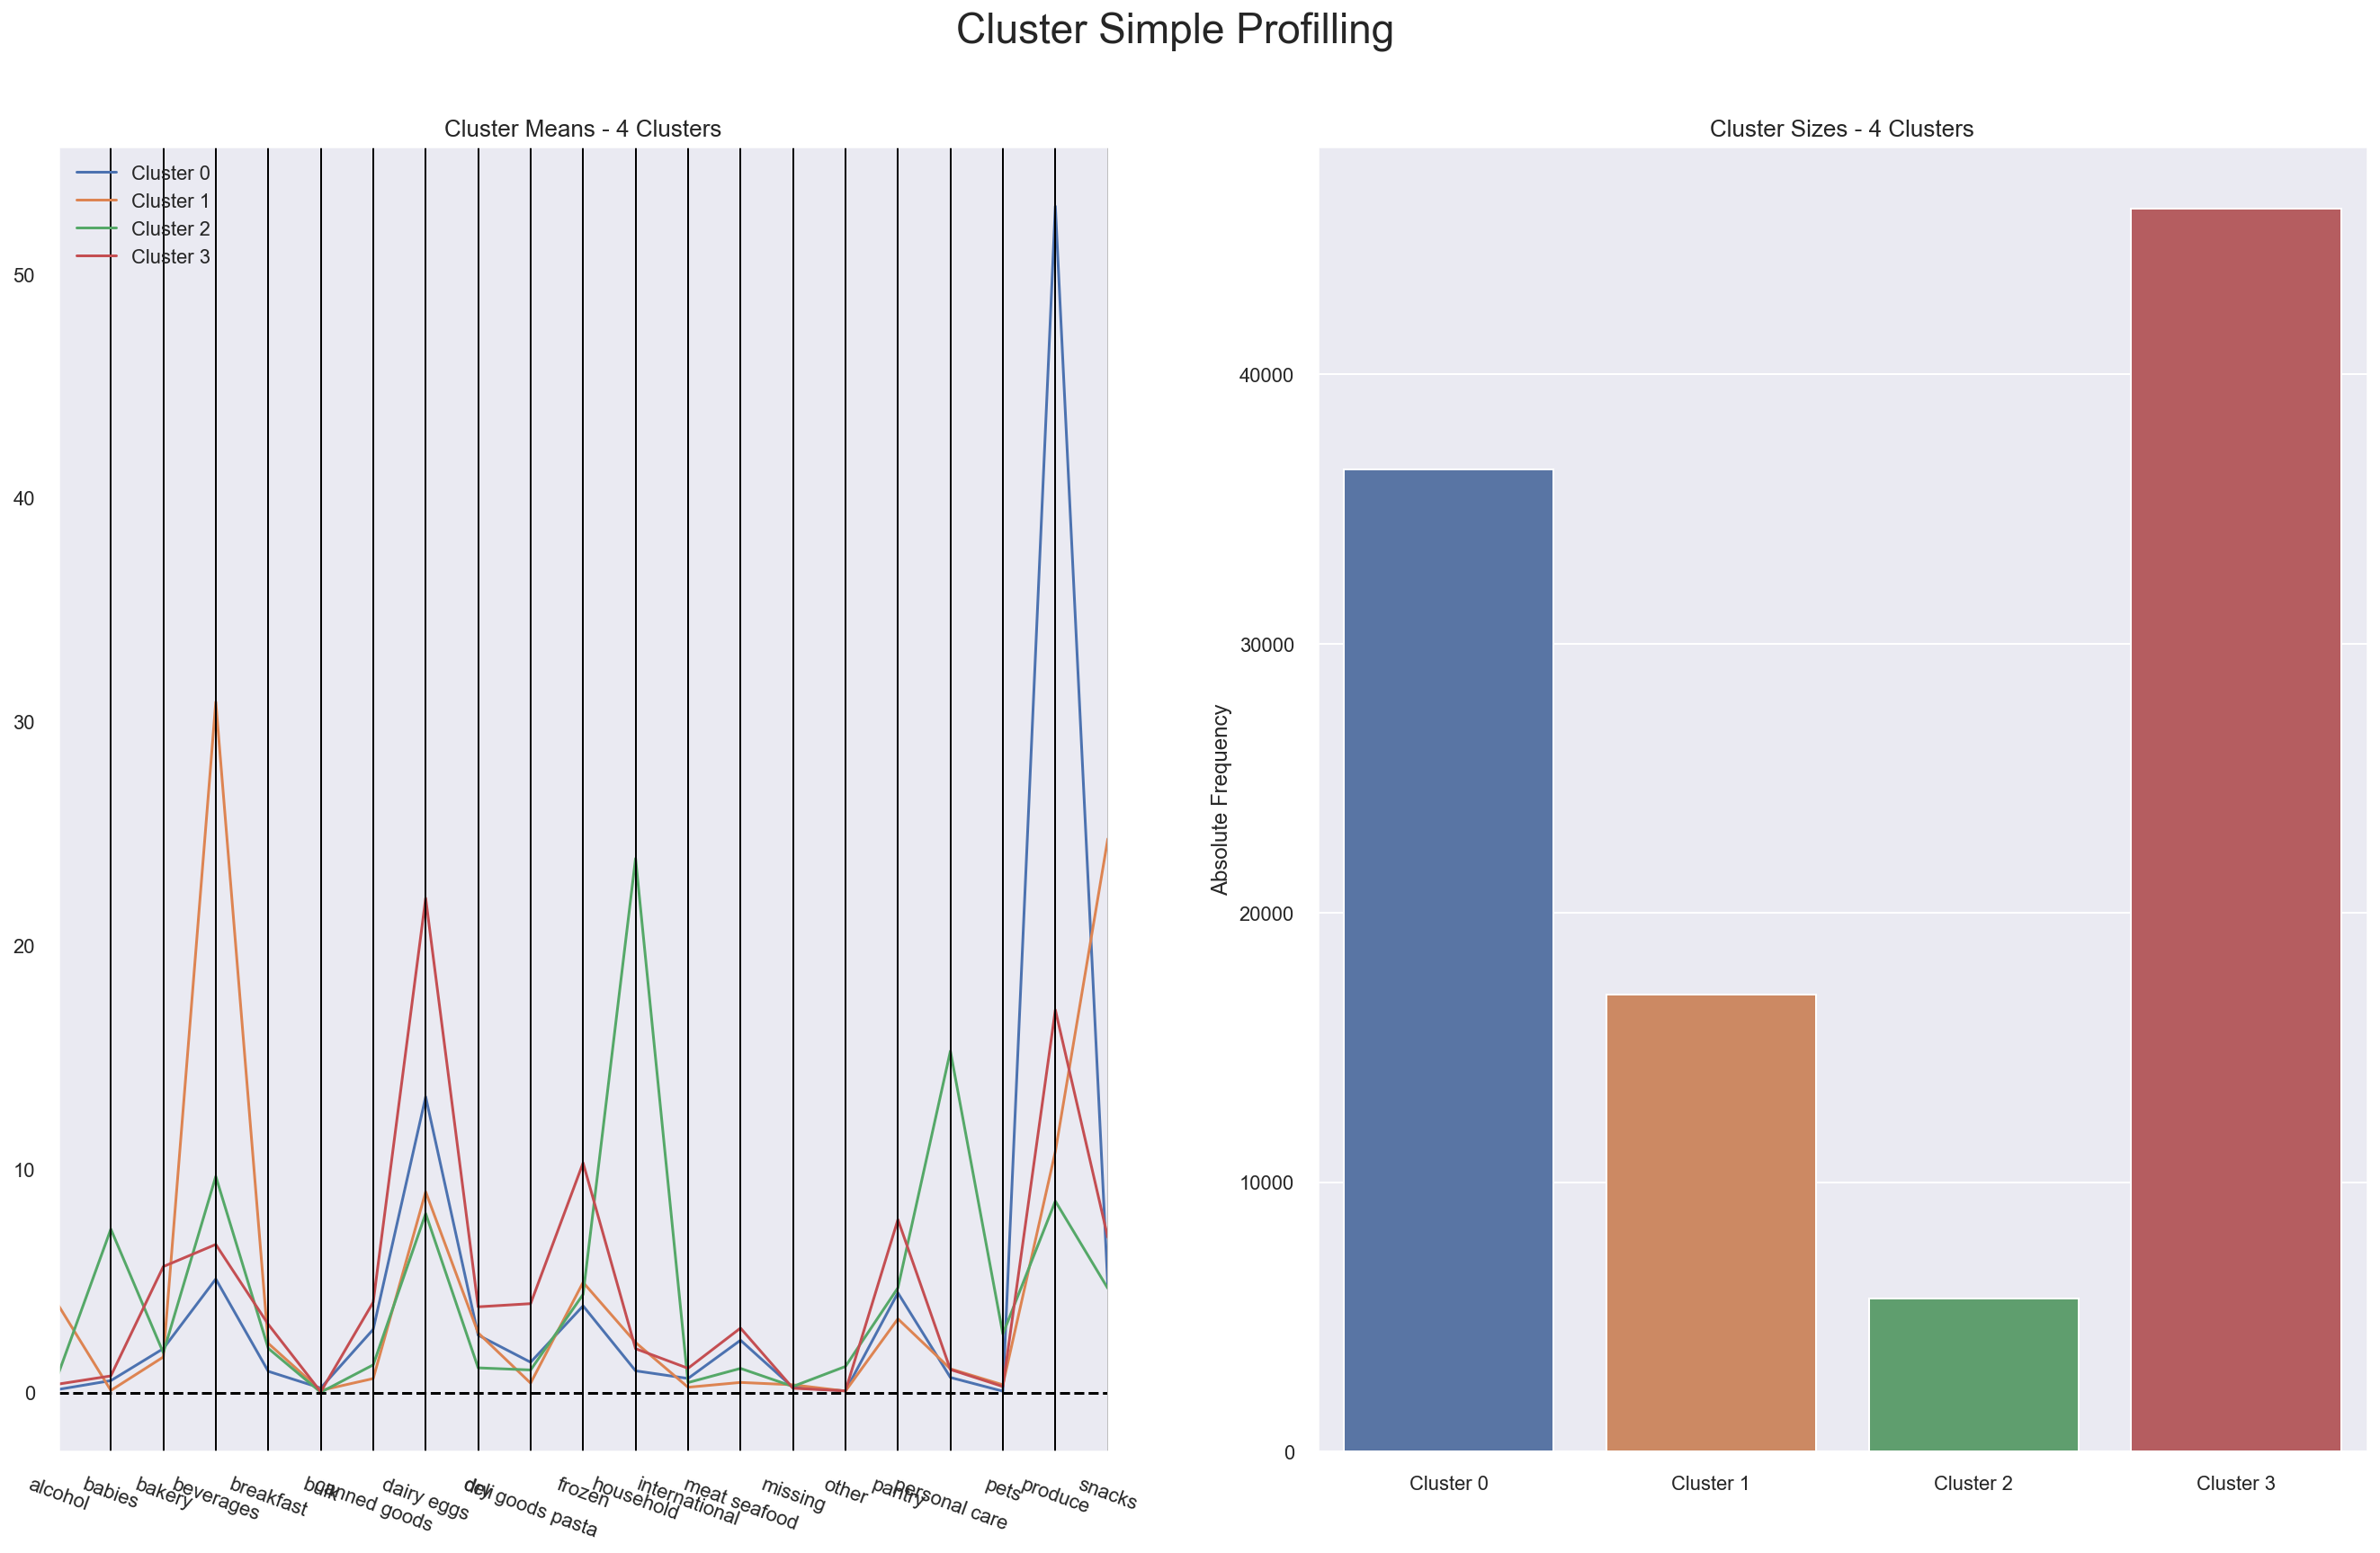

In [212]:
cluster_profiles(kmeans_data_clust_test, ["kmeans_labels"], figsize=(23, 13))

In [213]:
kmeans_summary = user_clustering_df_product.copy()
kmeans_summary['kmeans_labels'] = kmeans_data_clust_test['kmeans_labels'].reset_index().set_index(user_clustering_df_product.index).drop(columns='user_id')['kmeans_labels']
round(kmeans_summary.groupby("kmeans_labels").mean(), 2).T


kmeans_labels        0      1      2      3
department                                 
alcohol           0.14   3.90   0.84   0.38
babies            0.54   0.10   7.31   0.75
bakery            1.97   1.59   1.78   5.63
beverages         5.08  30.88   9.67   6.62
breakfast         0.95   2.20   1.98   3.05
bulk              0.20   0.10   0.02   0.03
canned goods      2.83   0.63   1.24   4.04
dairy eggs       13.23   8.98   8.01  22.11
deli              2.57   2.67   1.11   3.84
dry goods pasta   1.36   0.42   1.01   3.98
frozen            3.88   4.93   4.39  10.27
household         0.97   2.24  23.88   1.96
international     0.63   0.24   0.45   1.09
meat seafood      2.34   0.45   1.08   2.88
missing           0.23   0.35   0.28   0.20
other             0.08   0.07   1.17   0.08
pantry            4.46   3.30   4.68   7.73
personal care     0.68   1.06  15.27   1.03
pets              0.06   0.35   2.62   0.27
produce          53.04  10.78   8.56  17.11
snacks            4.77  24.76   4.66   6.94

## Clustering combining all variables - Kmeans

In [ ]:
user_clustering_df_combined

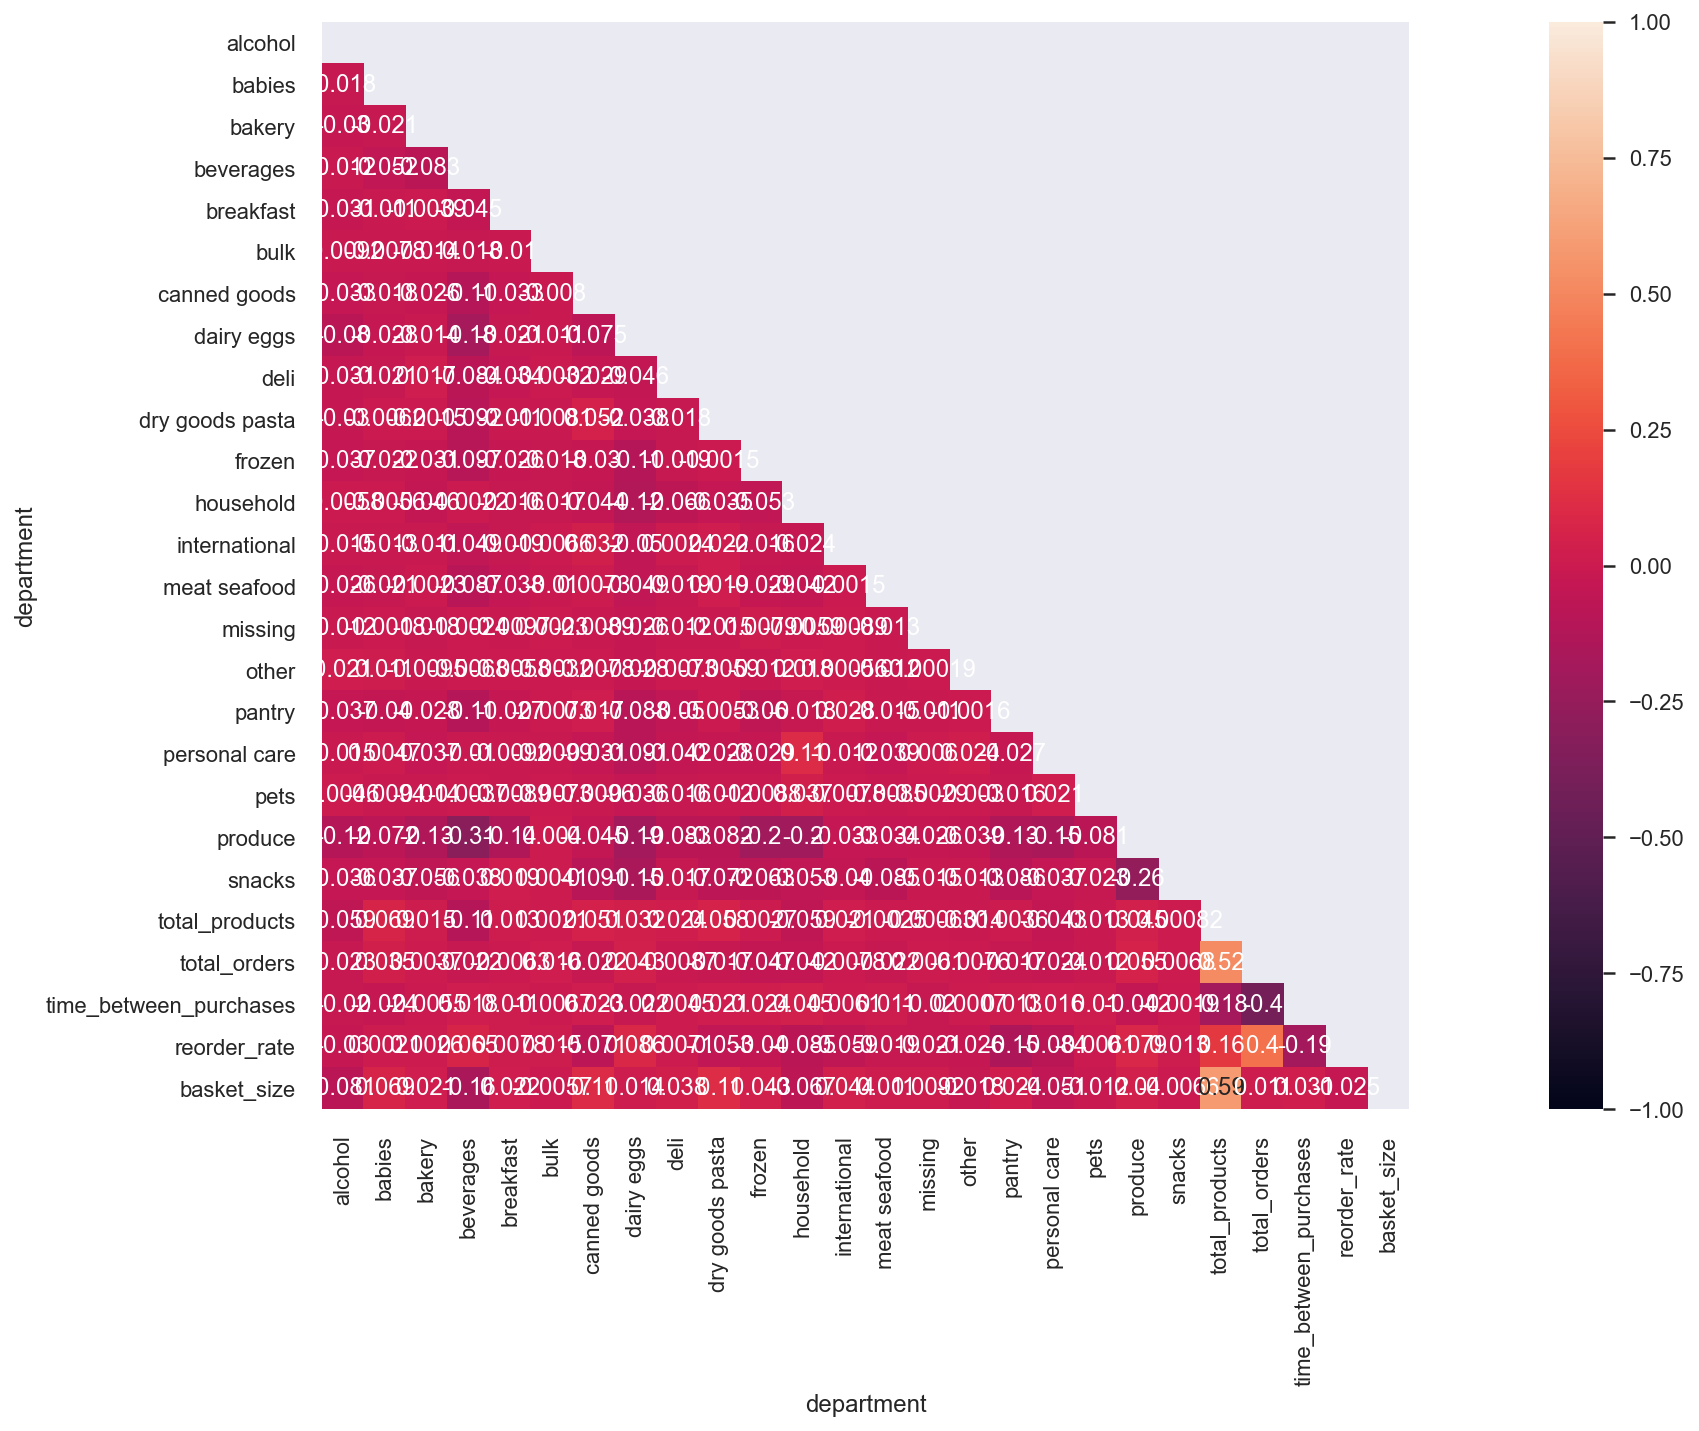

In [297]:
#Plot correlation matrix
data_test = user_clustering_df_combined

fig, axes = plt.subplots(1, 1, figsize=(25, 10))

mask = np.zeros_like(data_test.corr(method="pearson"), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(user_clustering_df_combined.corr(method="pearson"),vmin=-1, vmax=1, square=True, annot=True, mask=mask)

plt.show()

In [298]:
#Applying StandardScaler to metric variables
data_to_scale = user_clustering_df_combined.fillna(data_test['time_between_purchases'].mean()).copy()

scaler = StandardScaler()
metric_features_scaled = scaler.fit_transform(data_to_scale)
data_scaled = pd.DataFrame(metric_features_scaled, 
                           columns=data_to_scale.columns)
data_scaled

department   alcohol    babies    bakery  beverages  breakfast      bulk  \
0          -0.129483 -0.184594 -0.485675  -0.612484  -0.355800 -0.078516   
1          -0.129483 -0.184594 -0.485675  -0.295520  -0.355800 -0.078516   
2          -0.129483 -0.184594  0.092363   1.145278  -0.355800 -0.078516   
3          -0.129483 -0.184594 -0.485675  -0.612484  -0.355800 -0.078516   
4          -0.129483 -0.184594 -0.485675   1.030785  -0.355800 -0.078516   
...              ...       ...       ...        ...        ...       ...   
105268     -0.129483 -0.184594  0.207416  -0.612484  -0.355800 -0.078516   
105269     -0.129483 -0.184594  1.495178   0.248621  -0.355800 -0.078516   
105270     -0.129483 -0.184594 -0.485675   0.190772  -0.355800 -0.078516   
105271     -0.129483 -0.184594  0.580299  -0.380486   0.287566 -0.078516   
105272     -0.129483 -0.184594  0.669014   0.140757   0.341040 -0.078516   

department  canned goods  dairy eggs      deli  dry goods pasta  ...  \
0              -0.442095    0.127302  3.589061        -0.416099  ...   
1              -0.442095    0.637966 -0.453969        -0.416099  ...   
2               0.819652    0.032572  1.399272        -0.416099  ...   
3              -0.442095    0.032572  1.522327        -0.416099  ...   
4              -0.442095    0.127302 -0.453969        -0.416099  ...   
...                  ...         ...       ...              ...  ...   
105268         -0.442095    0.868831 -0.453969         1.364885  ...   
105269         -0.442095    0.779120 -0.453969        -0.416099  ...   
105270         -0.442095   -0.594778  0.534920        -0.416099  ...   
105271         -0.442095    0.675607  0.116829        -0.416099  ...   
105272          0.189536    0.032572  0.164272        -0.416099  ...   

department    pantry  personal care      pets   produce    snacks  \
0          -0.582982      -0.258857 -0.108467 -0.034584  1.308315   
1          -0.046874      -0.258857 -0.108467  0.151010  0.489132   
2          -0.582982      -0.258857 -0.108467 -0.850162  0.254367   
3           0.775634      -0.258857 -0.108467  0.656979 -0.637601   
4           3.122889      -0.258857 -0.108467 -0.426009 -0.637601   
...              ...            ...       ...       ...       ...   
105268     -0.582982      -0.258857  1.490523 -0.347638 -0.637601   
105269     -0.582982      -0.258857 -0.108467  0.636740 -0.637601   
105270     -0.582982      -0.258857 -0.108467 -0.921643  1.265501   
105271     -0.582982      -0.258857 -0.108467  0.447271 -0.088862   
105272     -0.157969      -0.258857 -0.108467 -0.491032 -0.043194   

department  total_products  total_orders  time_between_purchases  \
0                -0.409503     -0.746013               -0.714760   
1                -0.009181     -0.290343               -0.083100   
2                 0.241021     -0.746013                1.898727   
3                 0.541263     -0.689054                0.094908   
4                -0.409503     -0.632096                1.898727   
...                    ...           ...                     ...   
105268            0.040860     -0.802972               -0.243308   
105269           -0.609665     -0.746013               -0.356046   
105270           -0.209342      2.044969               -1.182797   
105271            0.341102      1.817134               -0.451441   
105272            0.241021     -0.347301                1.025002   

department  reorder_rate  basket_size  
0              -0.555680    -0.651245  
1              -0.201909    -0.532861  
2               0.954256     1.976873  
3              -0.331625     2.829236  
4              -0.847926     0.130087  
...                  ...          ...  
105268         -1.081722     1.408631  
105269          1.030797    -0.438154  
105270          0.632786    -0.899851  
105271          1.242755     0.414208  
105272         -0.117311    -0.296094  

[105273 rows x 26 columns]

In [299]:
df_pca = data_scaled.copy()

# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(df_pca)
pca_feat

array([[-5.04694299e-01, -3.70561115e-01, -3.78723686e-01, ...,
        -7.93624224e-02,  4.08548789e-01, -2.17386032e-04],
       [-3.19362511e-01, -3.92746505e-01, -3.12268758e-01, ...,
         1.39841973e-01,  3.89876954e-01,  1.06364449e-05],
       [-2.57326056e-02,  8.40410933e-01,  8.63508714e-01, ...,
        -7.53609686e-01, -5.16051734e-01,  2.55371668e-04],
       ...,
       [ 9.26251609e-01, -1.70367999e+00,  8.61853181e-01, ...,
         6.82126088e-01, -6.24774620e-01,  4.66768260e-04],
       [ 2.09049770e+00, -1.06017282e+00, -3.58285617e-01, ...,
         2.31253938e-01, -7.82312688e-01,  1.81373968e-05],
       [-7.92078529e-01, -1.02370508e-02,  6.35493458e-01, ...,
         3.91081948e-01,  4.01816228e-01,  4.69039430e-04]])

In [300]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference    Proportion  Cumulative
1   2.148230e+00    0.000000  8.262346e-02    0.082623
2   1.614540e+00   -0.533690  6.209711e-02    0.144721
3   1.441903e+00   -0.172637  5.545727e-02    0.200178
4   1.231172e+00   -0.210731  4.735230e-02    0.247530
5   1.158922e+00   -0.072250  4.457349e-02    0.292104
6   1.096175e+00   -0.062747  4.216018e-02    0.334264
7   1.082389e+00   -0.013786  4.162996e-02    0.375894
8   1.054482e+00   -0.027908  4.055660e-02    0.416450
9   1.036116e+00   -0.018366  3.985022e-02    0.456301
10  1.026499e+00   -0.009617  3.948036e-02    0.495781
11  1.014497e+00   -0.012002  3.901873e-02    0.534800
12  1.001774e+00   -0.012722  3.852941e-02    0.573329
13  9.972176e-01   -0.004557  3.835416e-02    0.611683
14  9.850550e-01   -0.012163  3.788637e-02    0.649570
15  9.837627e-01   -0.001292  3.783667e-02    0.687406
16  9.739840e-01   -0.009779  3.746057e-02    0.724867
17  9.709463e-01   -0.003038  3.734373e-02    0.762211
18  9.630080e-01   -0.007938  3.703842e-02    0.799249
19  9.418248e-01   -0.021183  3.622369e-02    0.835473
20  9.378651e-01   -0.003960  3.607139e-02    0.871544
21  9.332373e-01   -0.004628  3.589340e-02    0.907437
22  8.871602e-01   -0.046077  3.412122e-02    0.941559
23  7.546637e-01   -0.132497  2.902525e-02    0.970584
24  5.543091e-01   -0.200355  2.131938e-02    0.991903
25  2.105155e-01   -0.343794  8.096674e-03    1.000000
26  4.851911e-08   -0.210515  1.866102e-09    1.000000

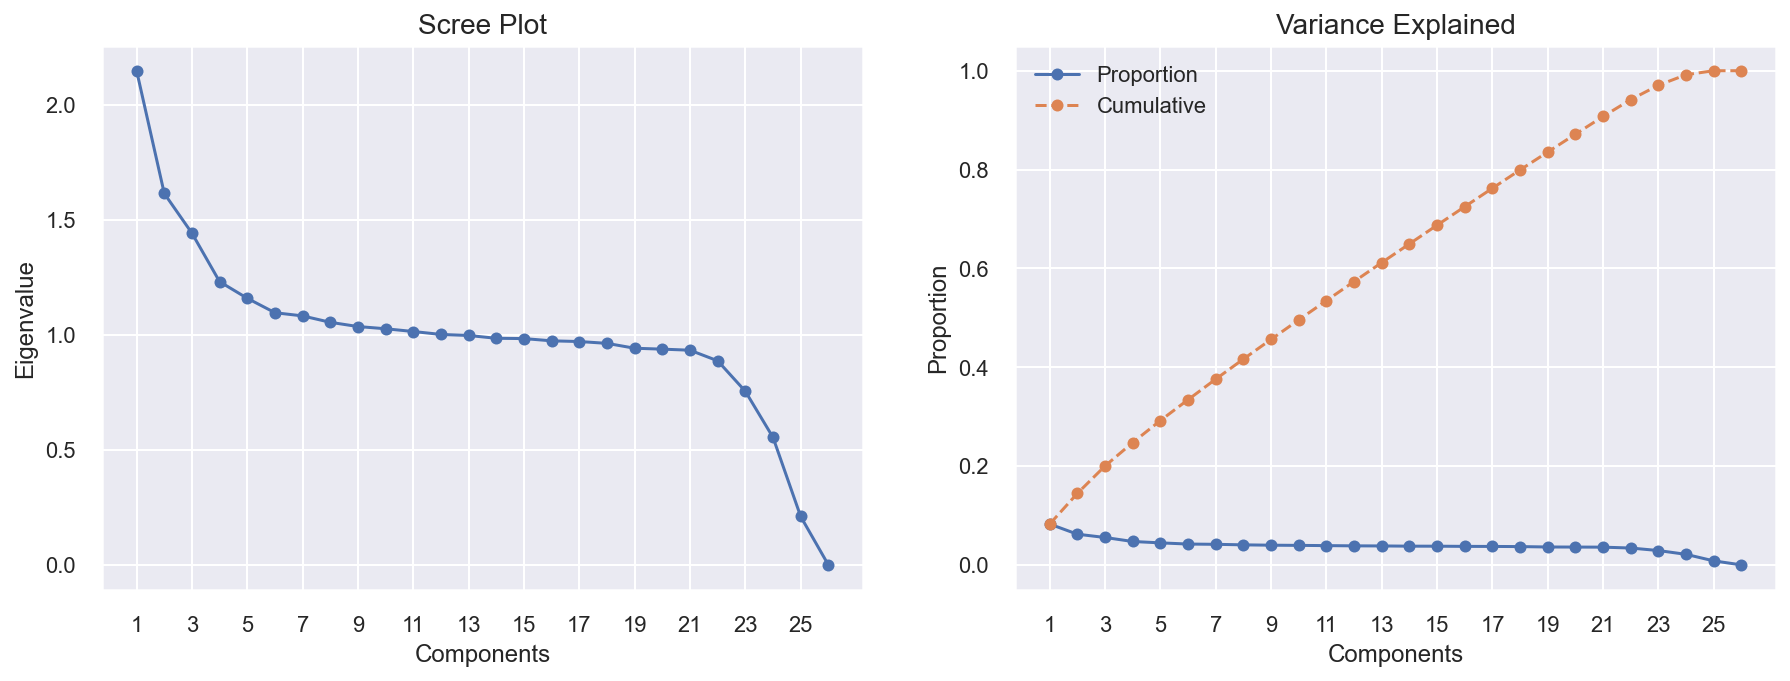

In [301]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [302]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=18)
pca_feat = pca.fit_transform(df_pca)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0      -0.504694 -0.370561 -0.378724 -1.307618  1.469317  0.271292  0.369855   
1      -0.319363 -0.392747 -0.312269 -0.277547  0.004057 -0.470127  0.230792   
2      -0.025733  0.840411  0.863509 -1.236286  1.265818 -0.330186 -0.651068   
3       1.070483  2.308124 -0.483541 -0.172675  0.327103 -0.084662 -0.029724   
4      -1.684446  0.949441  0.045376  0.312754 -0.568431  0.254286  1.741957   
...          ...       ...       ...       ...       ...       ...       ...   
105268 -0.028275  1.767959  0.554360 -0.922606 -0.688746 -0.043518 -1.747676   
105269 -0.100208 -0.917836 -1.407994 -0.966667 -0.740911 -0.181380 -0.184652   
105270  0.926252 -1.703680  0.861853  0.041947  1.022910  1.954610 -0.672078   
105271  2.090498 -1.060173 -0.358286 -0.737765 -0.218130 -0.205873 -0.100124   
105272 -0.792079 -0.010237  0.635493 -0.219691 -0.269940 -0.610158  0.184059   

             PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
0       2.358530 -0.800644 -0.362704  1.074515  0.565410 -0.480930 -0.214814   
1       0.062531  0.688154  0.012272 -0.174721  0.259832 -0.357408 -0.275645   
2      -0.707368 -1.500952  0.039365  1.381852  0.204202  0.051232 -0.283217   
3       0.610902 -0.890715 -0.451315  0.184665 -0.008134  0.136323 -1.426277   
4      -0.960741  0.499792 -0.067750  0.960425 -0.036584 -0.375621 -1.408909   
...          ...       ...       ...       ...       ...       ...       ...   
105268 -0.403786  0.403209 -0.217354 -0.716153  0.993071 -0.422105  0.060131   
105269  0.044746 -0.484323 -0.138411  0.349041 -0.425199  0.039334  0.286022   
105270  0.460343  0.775773 -0.556597 -0.139598 -0.156300 -0.024071  0.127867   
105271  0.355865  0.052541 -0.237489 -0.199611 -0.138820 -0.281767  0.424272   
105272  0.078334 -0.648755 -0.389035  0.138982 -0.163915 -0.096916  0.203614   

            PC14      PC15      PC16      PC17  
0      -0.034245  0.928824 -0.197615 -1.370065  
1      -0.469084  0.197125  0.151421 -0.277101  
2       0.136195  0.133865  0.930220 -0.267898  
3       0.211125  1.075293  0.736493 -0.412202  
4      -0.830243 -0.274212  1.458566  0.670422  
...          ...       ...       ...       ...  
105268  0.143270  0.314131  0.183750  0.318091  
105269  0.198902 -0.973837  0.200413  0.547634  
105270 -0.805000  1.643304 -1.485049  0.223722  
105271 -0.048326 -0.288346  0.033382  0.122992  
105272  0.005824 -0.667492  0.336093 -0.009305  

[105273 rows x 18 columns]

In [303]:
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

alcohol    babies    bakery  beverages  breakfast      bulk  canned goods  \
0 -0.129483 -0.184594 -0.485675  -0.612484    -0.3558 -0.078516     -0.442095   
1 -0.129483 -0.184594 -0.485675  -0.295520    -0.3558 -0.078516     -0.442095   
2 -0.129483 -0.184594  0.092363   1.145278    -0.3558 -0.078516      0.819652   
3 -0.129483 -0.184594 -0.485675  -0.612484    -0.3558 -0.078516     -0.442095   
4 -0.129483 -0.184594 -0.485675   1.030785    -0.3558 -0.078516     -0.442095   

   dairy eggs      deli  dry goods pasta  ...       PC8       PC9      PC10  \
0    0.127302  3.589061        -0.416099  ... -0.800644 -0.362704  1.074515   
1    0.637966 -0.453969        -0.416099  ...  0.688154  0.012272 -0.174721   
2    0.032572  1.399272        -0.416099  ... -1.500952  0.039365  1.381852   
3    0.032572  1.522327        -0.416099  ... -0.890715 -0.451315  0.184665   
4    0.127302 -0.453969        -0.416099  ...  0.499792 -0.067750  0.960425   

       PC11      PC12      PC13      PC14      PC15      PC16      PC17  
0  0.565410 -0.480930 -0.214814 -0.034245  0.928824 -0.197615 -1.370065  
1  0.259832 -0.357408 -0.275645 -0.469084  0.197125  0.151421 -0.277101  
2  0.204202  0.051232 -0.283217  0.136195  0.133865  0.930220 -0.267898  
3 -0.008134  0.136323 -1.426277  0.211125  1.075293  0.736493 -0.412202  
4 -0.036584 -0.375621 -1.408909 -0.830243 -0.274212  1.458566  0.670422  

[5 rows x 44 columns]

In [304]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca.corr()[pca_feat_names].loc[data_test.columns]
loadings.style.applymap(_color_red_or_green)

In [305]:
#Define data for clustering 
data_clust_test = pca_df
data_clust_test

PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0      -0.504694 -0.370561 -0.378724 -1.307618  1.469317  0.271292  0.369855   
1      -0.319363 -0.392747 -0.312269 -0.277547  0.004057 -0.470127  0.230792   
2      -0.025733  0.840411  0.863509 -1.236286  1.265818 -0.330186 -0.651068   
3       1.070483  2.308124 -0.483541 -0.172675  0.327103 -0.084662 -0.029724   
4      -1.684446  0.949441  0.045376  0.312754 -0.568431  0.254286  1.741957   
...          ...       ...       ...       ...       ...       ...       ...   
105268 -0.028275  1.767959  0.554360 -0.922606 -0.688746 -0.043518 -1.747676   
105269 -0.100208 -0.917836 -1.407994 -0.966667 -0.740911 -0.181380 -0.184652   
105270  0.926252 -1.703680  0.861853  0.041947  1.022910  1.954610 -0.672078   
105271  2.090498 -1.060173 -0.358286 -0.737765 -0.218130 -0.205873 -0.100124   
105272 -0.792079 -0.010237  0.635493 -0.219691 -0.269940 -0.610158  0.184059   

             PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
0       2.358530 -0.800644 -0.362704  1.074515  0.565410 -0.480930 -0.214814   
1       0.062531  0.688154  0.012272 -0.174721  0.259832 -0.357408 -0.275645   
2      -0.707368 -1.500952  0.039365  1.381852  0.204202  0.051232 -0.283217   
3       0.610902 -0.890715 -0.451315  0.184665 -0.008134  0.136323 -1.426277   
4      -0.960741  0.499792 -0.067750  0.960425 -0.036584 -0.375621 -1.408909   
...          ...       ...       ...       ...       ...       ...       ...   
105268 -0.403786  0.403209 -0.217354 -0.716153  0.993071 -0.422105  0.060131   
105269  0.044746 -0.484323 -0.138411  0.349041 -0.425199  0.039334  0.286022   
105270  0.460343  0.775773 -0.556597 -0.139598 -0.156300 -0.024071  0.127867   
105271  0.355865  0.052541 -0.237489 -0.199611 -0.138820 -0.281767  0.424272   
105272  0.078334 -0.648755 -0.389035  0.138982 -0.163915 -0.096916  0.203614   

            PC14      PC15      PC16      PC17  
0      -0.034245  0.928824 -0.197615 -1.370065  
1      -0.469084  0.197125  0.151421 -0.277101  
2       0.136195  0.133865  0.930220 -0.267898  
3       0.211125  1.075293  0.736493 -0.412202  
4      -0.830243 -0.274212  1.458566  0.670422  
...          ...       ...       ...       ...  
105268  0.143270  0.314131  0.183750  0.318091  
105269  0.198902 -0.973837  0.200413  0.547634  
105270 -0.805000  1.643304 -1.485049  0.223722  
105271 -0.048326 -0.288346  0.033382  0.122992  
105272  0.005824 -0.667492  0.336093 -0.009305  

[105273 rows x 18 columns]

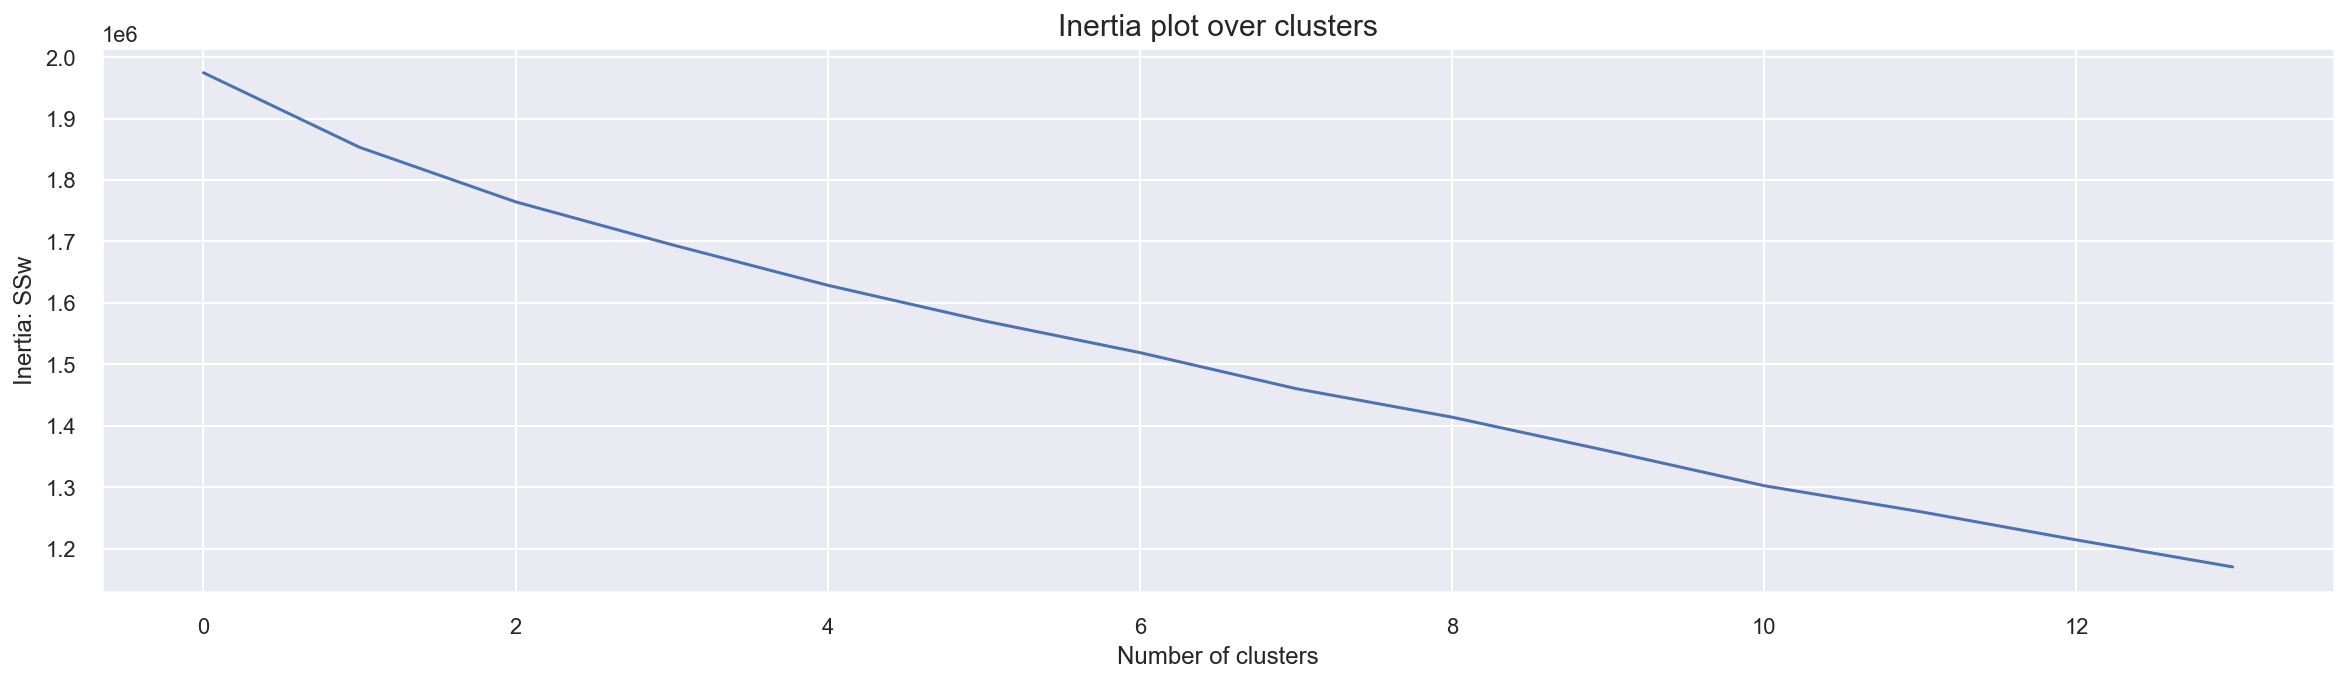

In [233]:
range_clusters = range(1, 15)
inertia = []

for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(data_clust_test)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

# The inertia plot
plt.figure(figsize=(20,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [306]:
# Performing kmeans and appending the cluster labels to a new dataframe that keeps the cluster labels
clust_labels, cent = doKmeans(data_clust_test, 5)
kmeans_data_clust_test = user_clustering_df_combined.copy()
kmeans_data_clust_test["kmeans_labels"] = clust_labels

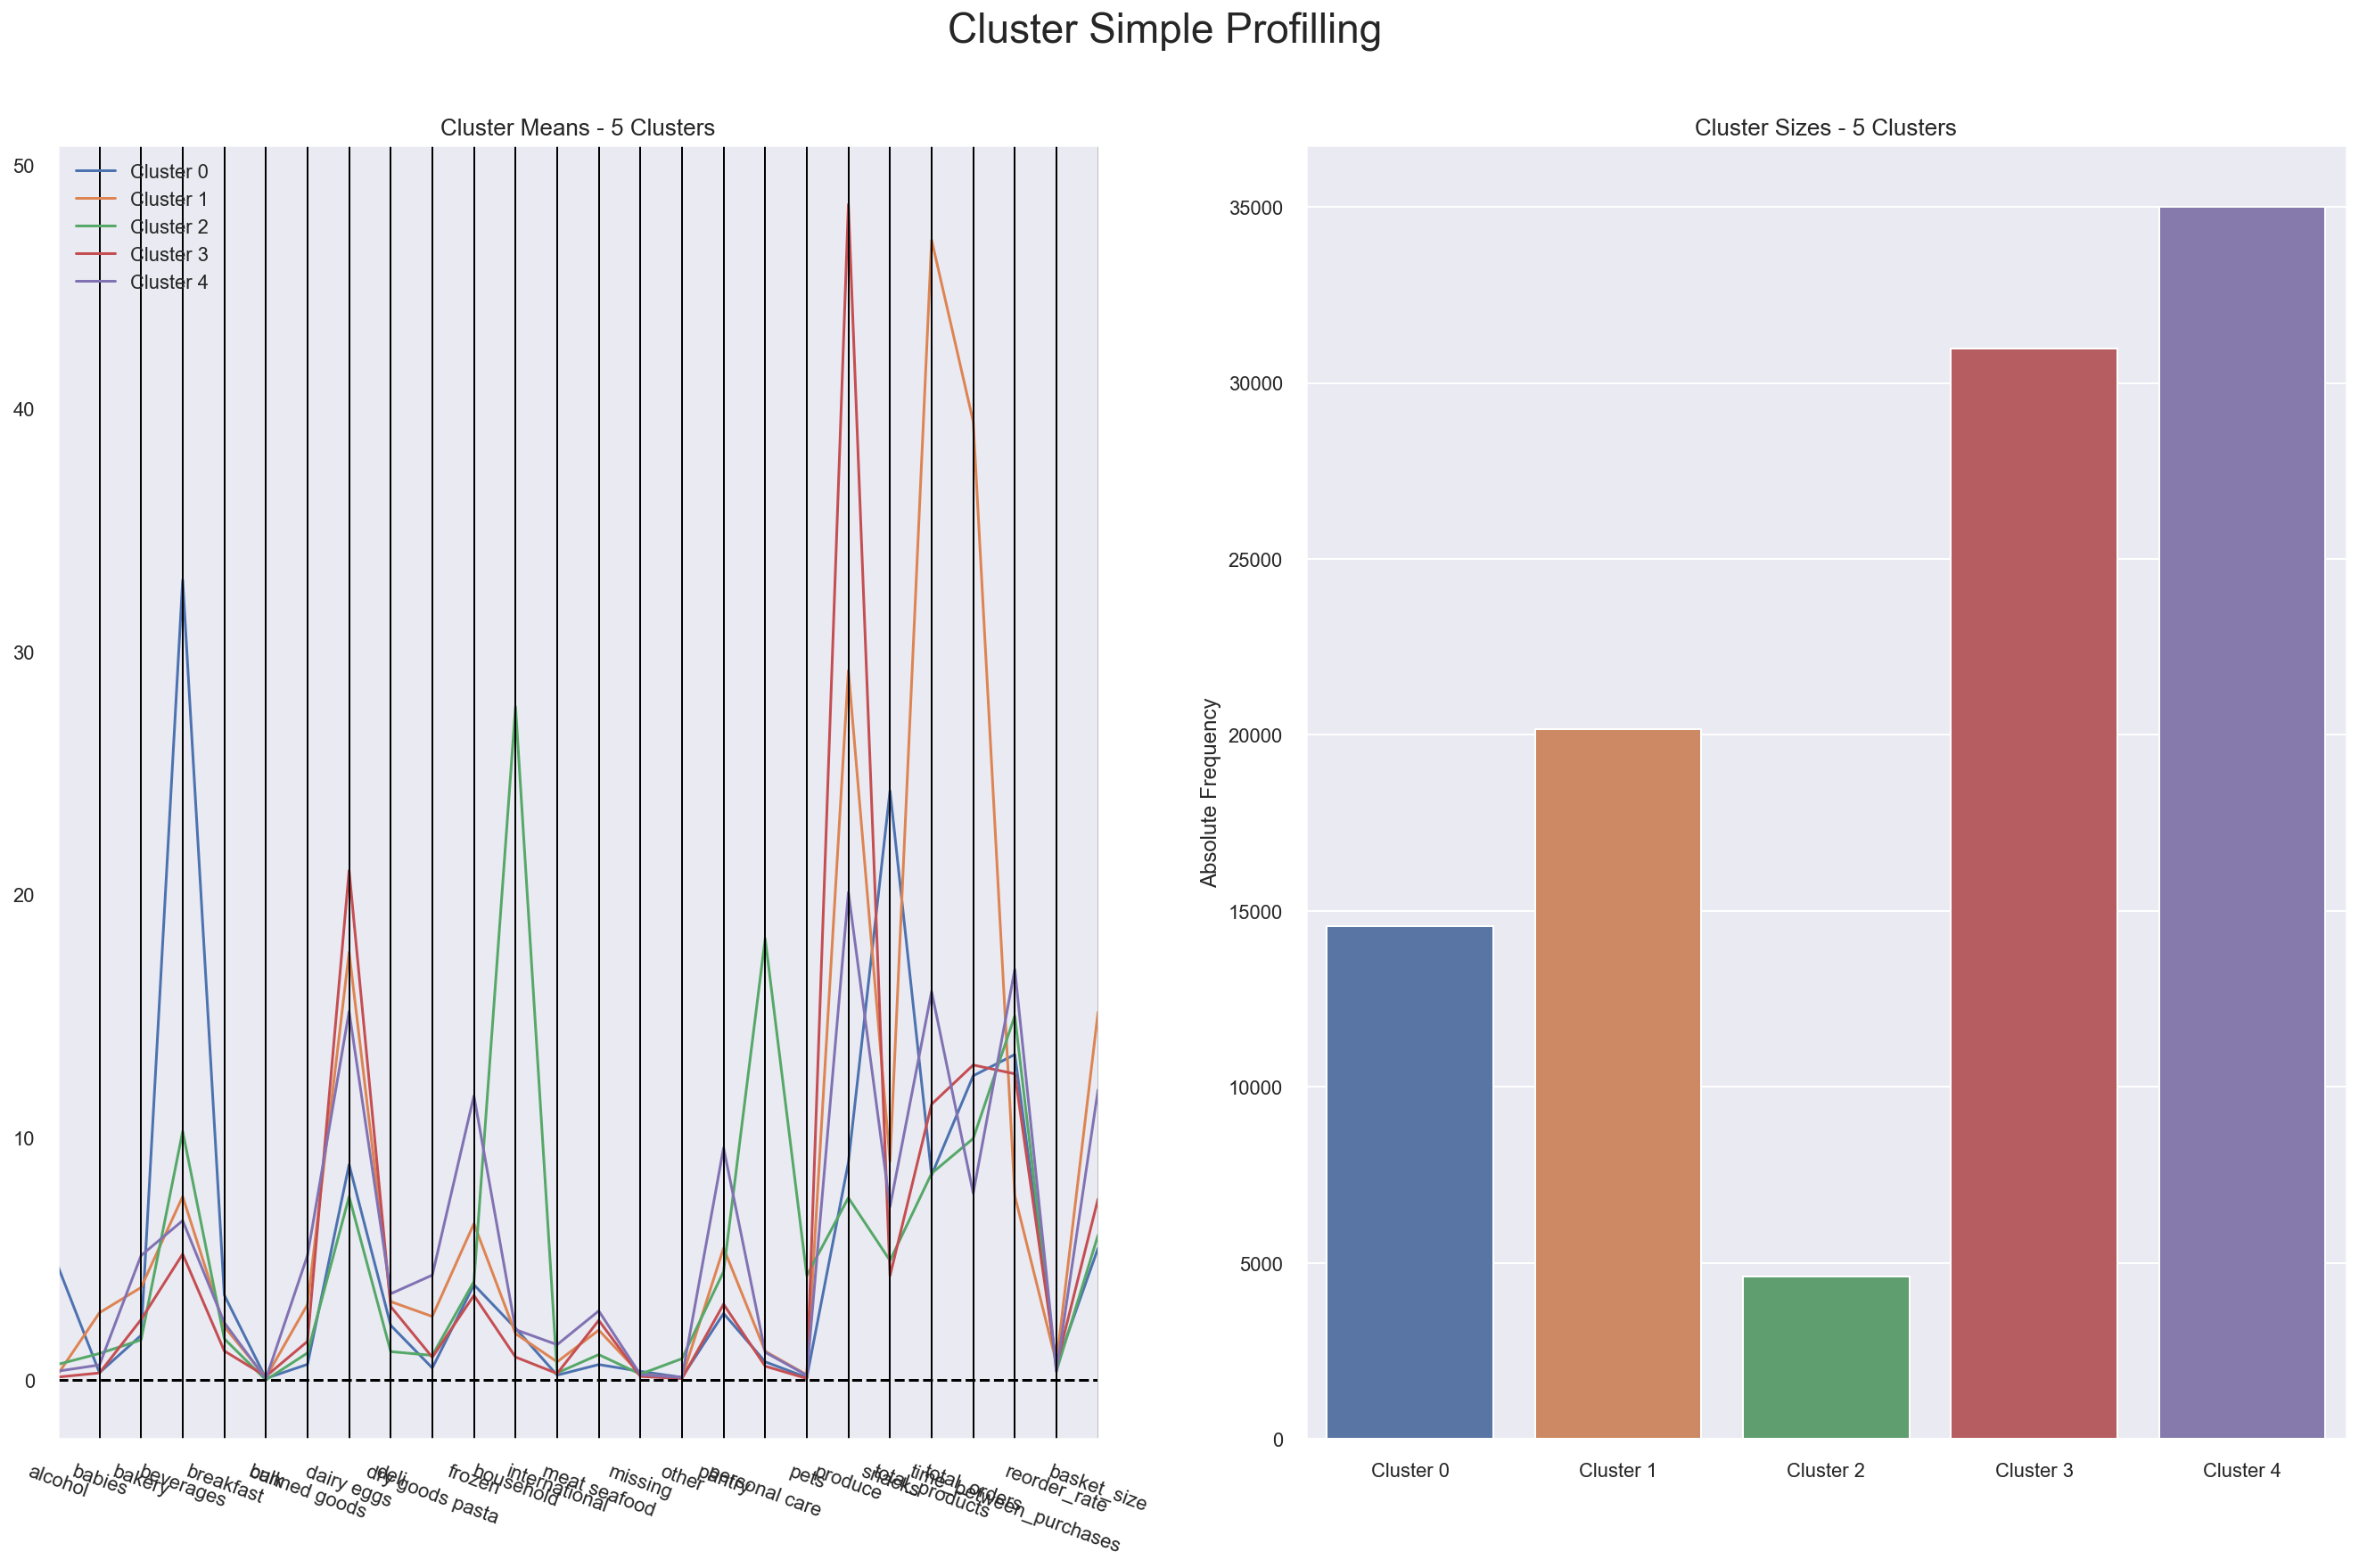

In [307]:
cluster_profiles(kmeans_data_clust_test, ["kmeans_labels"], figsize=(23, 13))

In [321]:


kmeans_summary = user_clustering_df_combined.copy()
kmeans_summary['kmeans_labels'] = kmeans_data_clust_test['kmeans_labels'].reset_index().set_index(user_clustering_df_combined.index).drop(columns='user_id')['kmeans_labels']

#calculate %of users, %of orders and %of products for each cluster
user_orders = kmeans_summary.groupby("kmeans_labels")['total_orders'].sum()
user_products = kmeans_summary.groupby("kmeans_labels")['total_products'].sum()
user_count = kmeans_summary.groupby("kmeans_labels")['total_orders'].count()

kmeans_summary = kmeans_summary.groupby("kmeans_labels").mean()

kmeans_summary['% of users'] = (user_count/user_count.sum())*100
kmeans_summary['`% of orders'] = (user_orders/user_orders.sum())*100
kmeans_summary['% of products'] = (user_products/user_products.sum())*100

round(kmeans_summary, 2).T


kmeans_labels               0      1      2      3      4
department                                               
alcohol                  4.70   0.25   0.66   0.13   0.38
babies                   0.31   2.78   1.10   0.30   0.63
bakery                   1.85   3.82   1.66   2.50   5.14
beverages               32.94   7.57  10.25   5.20   6.57
breakfast                3.51   2.21   1.71   1.21   2.38
bulk                     0.08   0.12   0.01   0.17   0.06
canned goods             0.66   3.12   1.13   1.60   5.14
dairy eggs               8.88  17.62   7.56  20.98  15.18
deli                     2.26   3.24   1.18   3.04   3.56
dry goods pasta          0.51   2.63   1.03   0.95   4.33
frozen                   3.93   6.45   4.06   3.50  11.71
household                2.14   1.92  27.73   0.96   2.09
international            0.21   0.76   0.30   0.28   1.47
meat seafood             0.65   2.07   1.06   2.47   2.86
missing                  0.37   0.26   0.25   0.16   0.23
other                    0.12   0.10   0.89   0.07   0.12
pantry                   2.75   5.44   4.47   3.13   9.57
personal care            0.76   1.19  18.18   0.58   1.16
pets                     0.12   0.23   4.31   0.08   0.21
produce                  8.97  29.21   7.51  48.40  20.08
snacks                  24.26   9.01   4.93   4.30   7.15
total_products           8.44  46.93   8.52  11.36  16.00
total_orders            12.53  39.45   9.95  12.98   7.70
time_between_purchases  13.41   7.59  15.00  12.61  16.91
reorder_rate             0.59   0.72   0.38   0.62   0.36
basket_size              5.44  15.15   5.97   7.47  11.95
% of users              13.82  19.14   4.37  29.42  33.24
`% of orders            10.76  46.91   2.70  23.72  15.91
% of products            6.08  46.82   1.94  17.43  27.73

## Clustering combining all variables - SOMs

In [322]:
#Applying StandardScaler to metric variables
data_to_scale = user_clustering_df_combined.fillna(data_test['time_between_purchases'].mean()).copy()

scaler = StandardScaler()
metric_features_scaled = scaler.fit_transform(data_to_scale)
data_scaled = pd.DataFrame(metric_features_scaled, 
                           columns=data_to_scale.columns)
data_scaled

department   alcohol    babies    bakery  beverages  breakfast      bulk  \
0          -0.129483 -0.184594 -0.485675  -0.612484  -0.355800 -0.078516   
1          -0.129483 -0.184594 -0.485675  -0.295520  -0.355800 -0.078516   
2          -0.129483 -0.184594  0.092363   1.145278  -0.355800 -0.078516   
3          -0.129483 -0.184594 -0.485675  -0.612484  -0.355800 -0.078516   
4          -0.129483 -0.184594 -0.485675   1.030785  -0.355800 -0.078516   
...              ...       ...       ...        ...        ...       ...   
105268     -0.129483 -0.184594  0.207416  -0.612484  -0.355800 -0.078516   
105269     -0.129483 -0.184594  1.495178   0.248621  -0.355800 -0.078516   
105270     -0.129483 -0.184594 -0.485675   0.190772  -0.355800 -0.078516   
105271     -0.129483 -0.184594  0.580299  -0.380486   0.287566 -0.078516   
105272     -0.129483 -0.184594  0.669014   0.140757   0.341040 -0.078516   

department  canned goods  dairy eggs      deli  dry goods pasta  ...  \
0              -0.442095    0.127302  3.589061        -0.416099  ...   
1              -0.442095    0.637966 -0.453969        -0.416099  ...   
2               0.819652    0.032572  1.399272        -0.416099  ...   
3              -0.442095    0.032572  1.522327        -0.416099  ...   
4              -0.442095    0.127302 -0.453969        -0.416099  ...   
...                  ...         ...       ...              ...  ...   
105268         -0.442095    0.868831 -0.453969         1.364885  ...   
105269         -0.442095    0.779120 -0.453969        -0.416099  ...   
105270         -0.442095   -0.594778  0.534920        -0.416099  ...   
105271         -0.442095    0.675607  0.116829        -0.416099  ...   
105272          0.189536    0.032572  0.164272        -0.416099  ...   

department    pantry  personal care      pets   produce    snacks  \
0          -0.582982      -0.258857 -0.108467 -0.034584  1.308315   
1          -0.046874      -0.258857 -0.108467  0.151010  0.489132   
2          -0.582982      -0.258857 -0.108467 -0.850162  0.254367   
3           0.775634      -0.258857 -0.108467  0.656979 -0.637601   
4           3.122889      -0.258857 -0.108467 -0.426009 -0.637601   
...              ...            ...       ...       ...       ...   
105268     -0.582982      -0.258857  1.490523 -0.347638 -0.637601   
105269     -0.582982      -0.258857 -0.108467  0.636740 -0.637601   
105270     -0.582982      -0.258857 -0.108467 -0.921643  1.265501   
105271     -0.582982      -0.258857 -0.108467  0.447271 -0.088862   
105272     -0.157969      -0.258857 -0.108467 -0.491032 -0.043194   

department  total_products  total_orders  time_between_purchases  \
0                -0.409503     -0.746013               -0.714760   
1                -0.009181     -0.290343               -0.083100   
2                 0.241021     -0.746013                1.898727   
3                 0.541263     -0.689054                0.094908   
4                -0.409503     -0.632096                1.898727   
...                    ...           ...                     ...   
105268            0.040860     -0.802972               -0.243308   
105269           -0.609665     -0.746013               -0.356046   
105270           -0.209342      2.044969               -1.182797   
105271            0.341102      1.817134               -0.451441   
105272            0.241021     -0.347301                1.025002   

department  reorder_rate  basket_size  
0              -0.555680    -0.651245  
1              -0.201909    -0.532861  
2               0.954256     1.976873  
3              -0.331625     2.829236  
4              -0.847926     0.130087  
...                  ...          ...  
105268         -1.081722     1.408631  
105269          1.030797    -0.438154  
105270          0.632786    -0.899851  
105271          1.242755     0.414208  
105272         -0.117311    -0.296094  

[105273 rows x 26 columns]

In [339]:
data_som = data_scaled

In [348]:
#Producing SOM clustering based on proportional product data
sm = sompy.SOMFactory().build(data=data_som.values, 
                        mapsize=(10,10),
                        normalization='var',
                        initialization='random',
                        component_names=data_som.columns,
                        lattice='hexa',
                        training='seq')

sm.train(n_job=4,
         verbose=None,
         train_rough_len=100,
         train_finetune_len=100)

#Obtaining SOM's BMUs labels
som_data_socioeconomical_clust_test = pd.DataFrame(np.concatenate((sm._data, np.expand_dims(sm._bmu[0],1)), axis=1),
                               index=data_som.index, columns=np.append(data_som.columns,"labels_som"))

sm.calculate_quantization_error()

0.4375466079757445

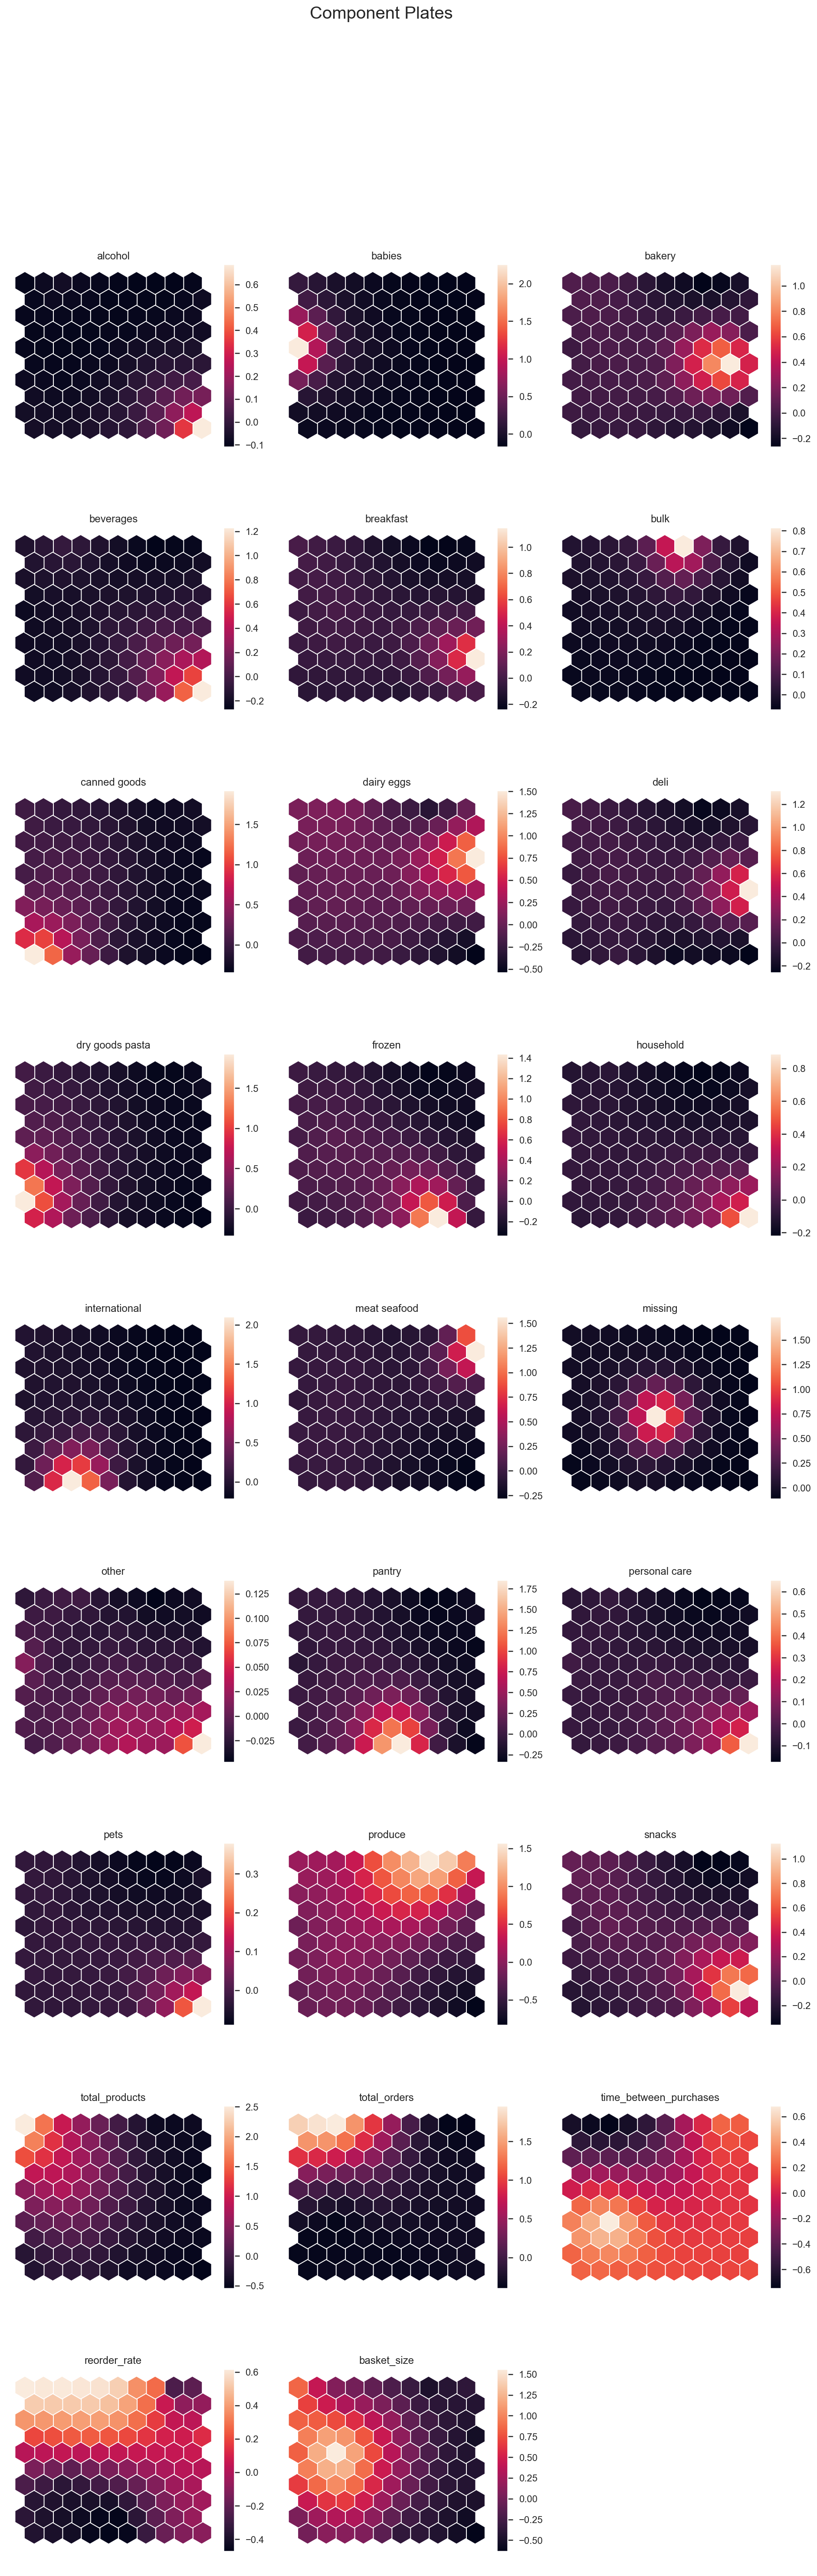

In [349]:
# Visualizing the Component plates (feature values)
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Plates", fontsize=20)
plt.show()

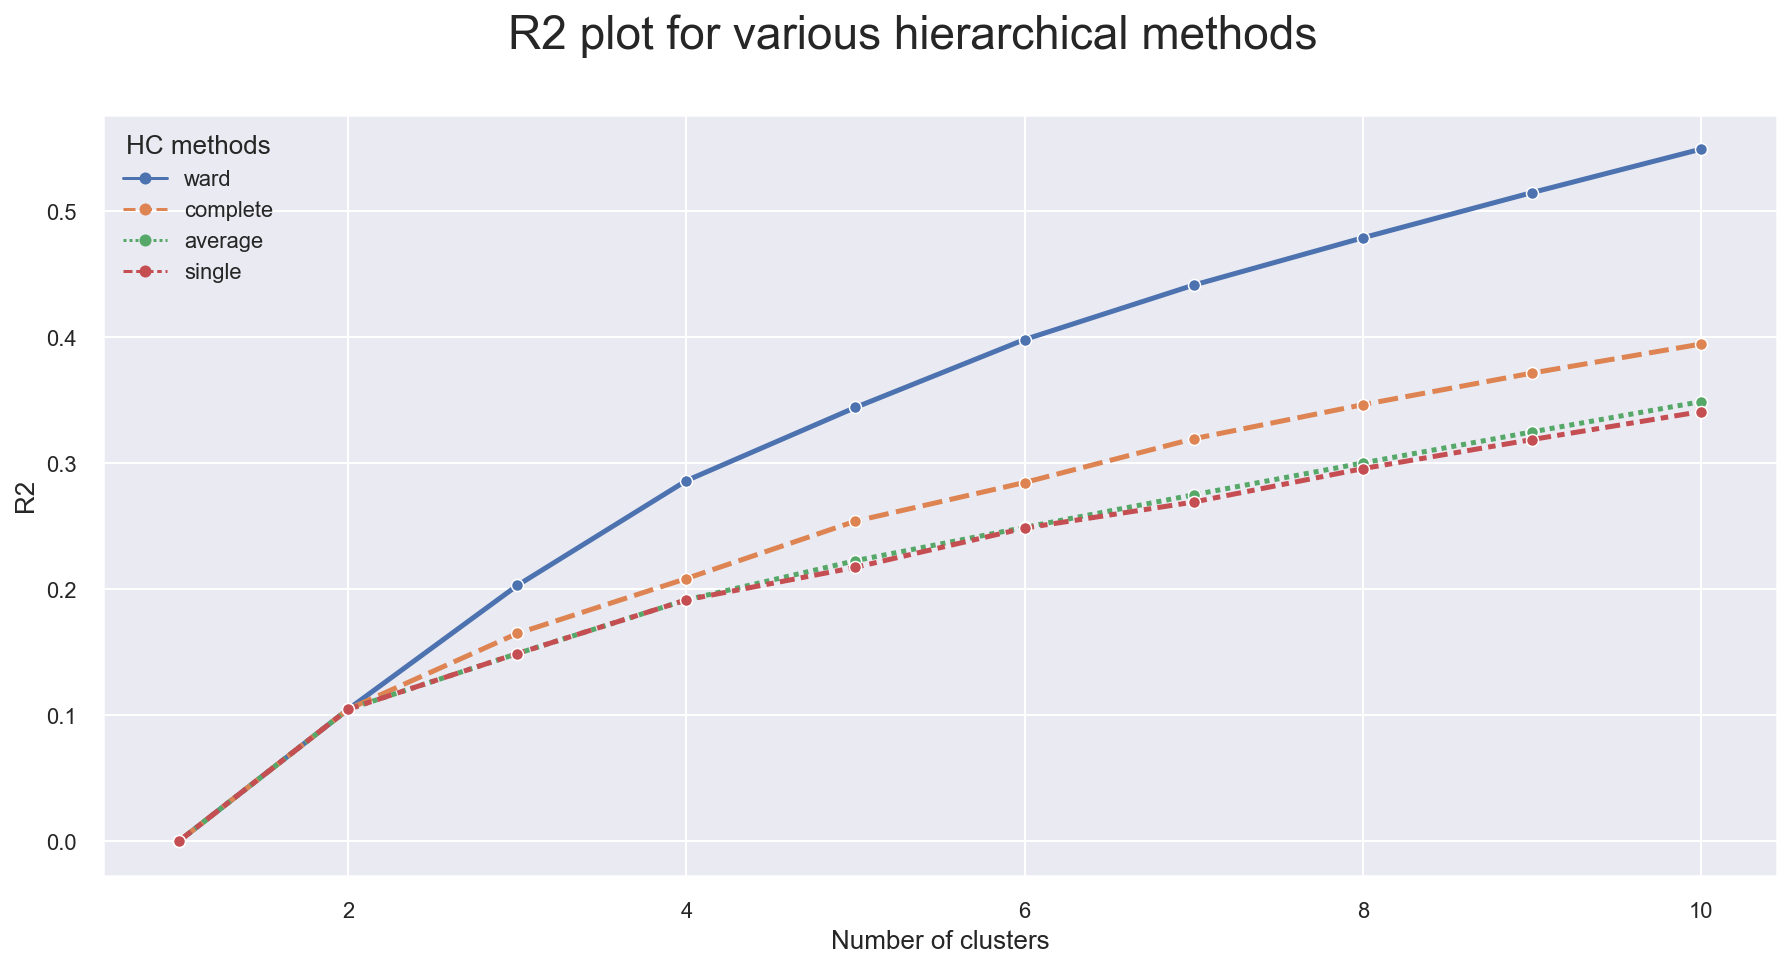

In [350]:
# Getting the centroids of each cluster given by the BMUs of each observation
som_units = som_data_socioeconomical_clust_test.groupby("labels_som").mean()

# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Function defined above to obtain the R2 statistic
r2_hc_methods = pd.DataFrame(data=np.concatenate([np.expand_dims(get_r2_hc(df=som_units, link=i, max_nclus=10), 1) for i in hc_methods], axis=1),
                             index=range(1,10+1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(15,7))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=23)
#plt.gca().invert_xaxis()
plt.legend(title="HC methods", title_fontsize=13)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2", fontsize=13)

plt.show()

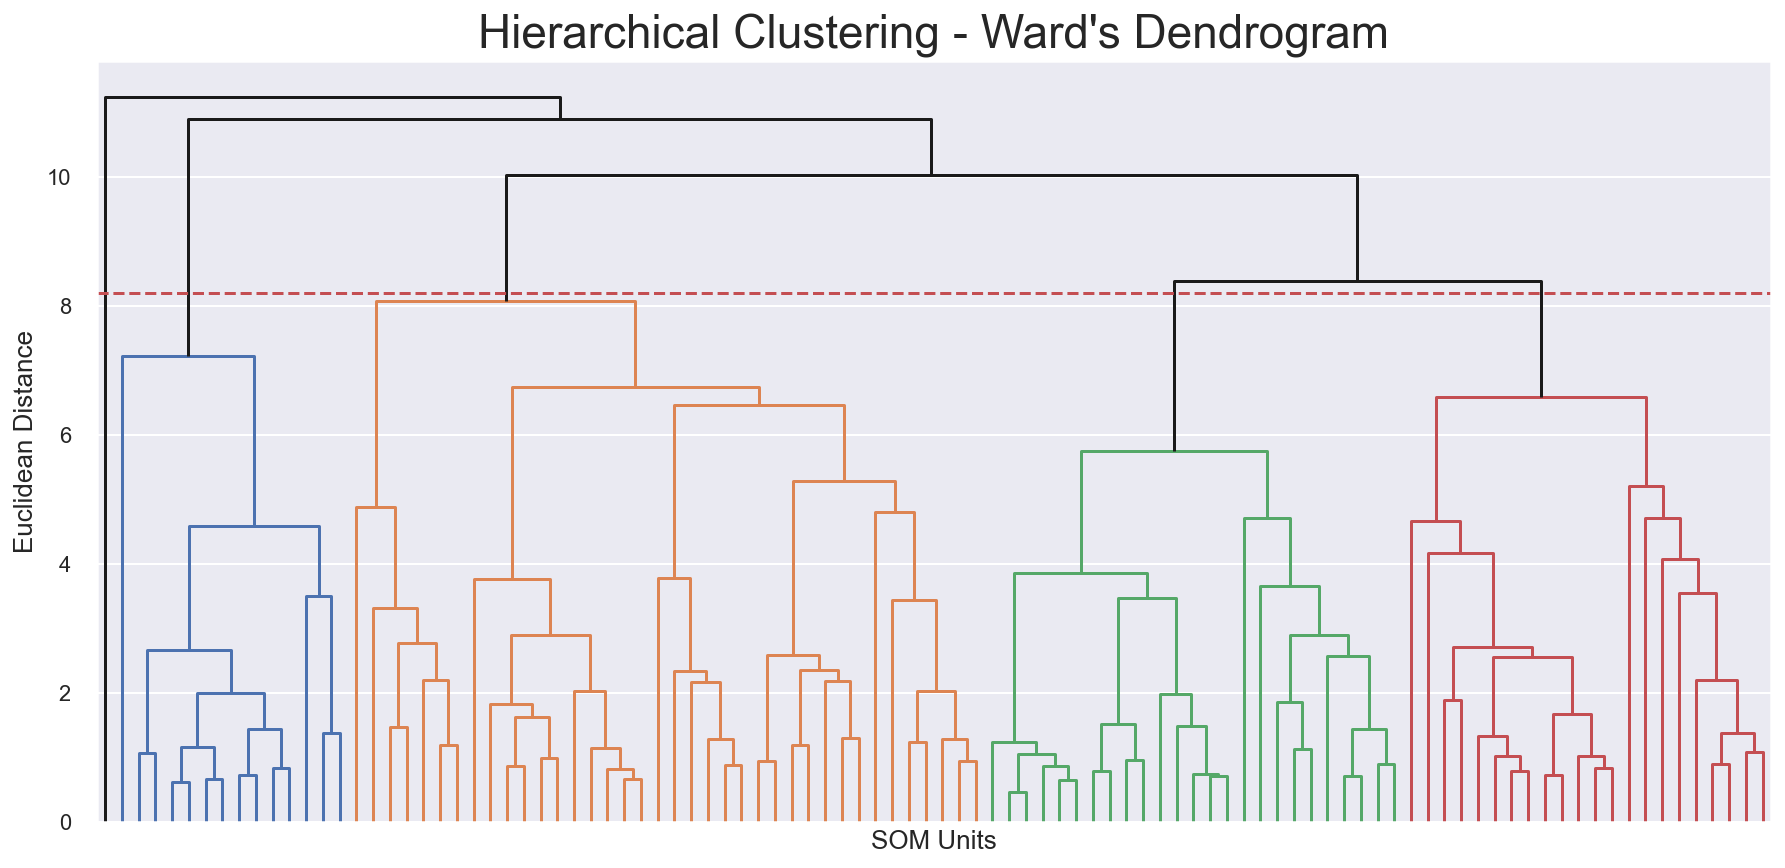

In [409]:
# Defining method to use
HCM = "ward"

# Hierarchical clustering assessment using scipy
Z = linkage(som_units, method=HCM)

sns.set()
fig = plt.figure(figsize=(15,7))

# Dendrogram
set_link_color_palette(list(sns.color_palette().as_hex()))
dendrogram(Z, color_threshold=8.2, orientation='top', no_labels=True, above_threshold_color='k')

plt.hlines(8.2, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering - Ward\'s Dendrogram', fontsize=23)
plt.xlabel('SOM Units', fontsize=13)
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

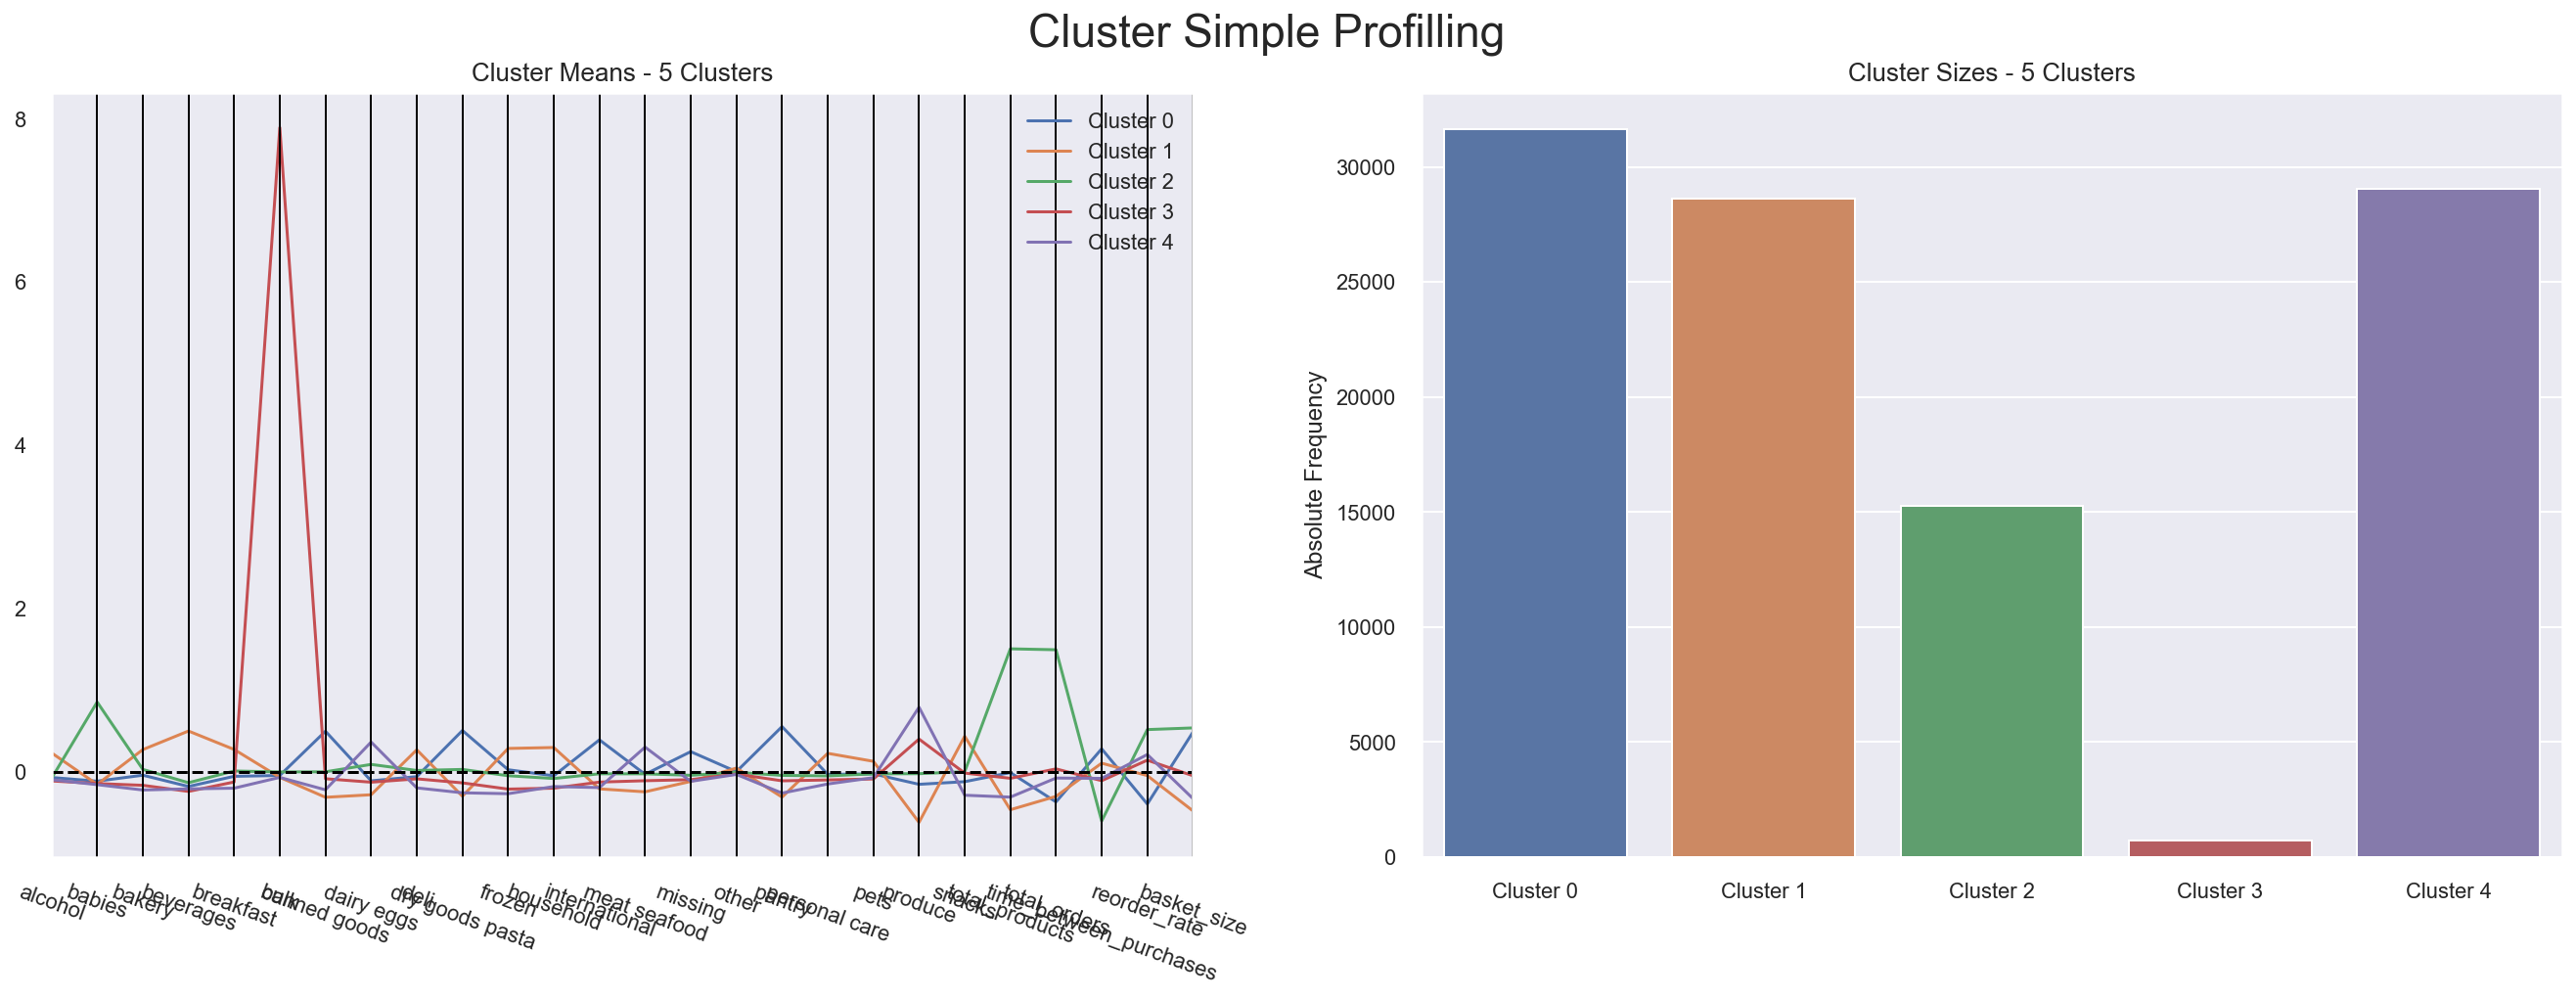

In [352]:
# Defining numbers of clusters
CLUSN = 5

# Hierarchical Clustering with sklearn
estimator = AgglomerativeClustering(n_clusters=CLUSN, linkage=HCM)
labels = estimator.fit_predict(som_units)

# Getting the HC labels for each SOM Unit
som_units_hc = pd.DataFrame(np.concatenate((som_units.values, np.expand_dims(labels,1)), axis=1), 
                            index=som_units.index, columns=np.append(som_units.columns,["labels_som_hc_5"]))

# Getting the HC labels for each observation in the main dataframe
som_data_socioeconomical_clust_test = som_data_socioeconomical_clust_test.merge(right=som_units_hc.loc[:,"labels_som_hc_5"], 
                                           left_on="labels_som", right_index=True).sort_index()
# Cluster Simple Profilling
cluster_profiles(som_data_socioeconomical_clust_test.drop("labels_som", axis=1), ["labels_som_hc_5"], (23, 7))


In [353]:
som_summary = user_clustering_df_combined.copy()
som_summary['labels_som_hc_5'] = som_data_socioeconomical_clust_test.drop("labels_som", axis=1)['labels_som_hc_5'].reset_index().set_index(user_clustering_df_combined.index).drop(columns='index')['labels_som_hc_5']

#calculate %of users, %of orders and %of products for each cluster
user_orders = som_summary.groupby("labels_som_hc_5")['total_orders'].sum()
user_products = som_summary.groupby("labels_som_hc_5")['total_products'].sum()
user_count = som_summary.groupby("labels_som_hc_5")['total_orders'].count()

som_summary = som_summary.groupby("labels_som_hc_5").mean()

som_summary['% of users'] = (user_count/user_count.sum())*100
som_summary['`% of orders'] = (user_orders/user_orders.sum())*100
som_summary['% of products'] = (user_products/user_products.sum())*100

round(som_summary, 2).T

labels_som_hc_5           0.0    1.0    2.0    3.0    4.0
department                                               
alcohol                  0.39   2.47   0.31   0.10   0.20
babies                   0.33   0.14   5.19   0.19   0.12
bakery                   3.18   5.44   3.69   2.29   1.87
beverages                7.13  18.41   7.89   6.12   6.64
breakfast                1.78   3.75   2.17   1.36   0.91
bulk                     0.04   0.01   0.10  10.43   0.01
canned goods             6.18   0.84   2.90   2.34   1.44
dairy eggs              14.34  11.62  17.55  14.07  21.92
deli                     2.64   4.86   3.15   2.46   1.71
dry goods pasta          5.16   0.64   2.48   1.56   0.87
frozen                   7.14  10.16   6.28   4.38   3.73
household                2.38   5.51   2.08   1.01   1.19
international            1.99   0.08   0.67   0.35   0.13
meat seafood             2.01   0.74   2.04   1.54   3.97
missing                  0.70   0.01   0.15   0.05   0.01
other                    0.13   0.20   0.12   0.09   0.08
pantry                  11.13   2.65   5.26   4.60   3.13
personal care            1.46   3.14   1.34   1.01   0.69
pets                     0.25   0.73   0.25   0.05   0.10
produce                 24.44  13.59  27.47  37.32  46.39
snacks                   7.19  15.00   8.91   8.68   4.87
total_products          18.93   9.83  49.24  17.53  12.93
total_orders             9.56  10.76  42.30  16.67  14.70
time_between_purchases  15.85  14.14   7.73  12.12  12.37
reorder_rate             0.41   0.52   0.70   0.58   0.60
basket_size             13.49   6.69  13.85   9.72   7.75
% of users              30.06  27.19  14.49   0.69  27.58
`% of orders            17.86  18.17  38.08   0.71  25.18
% of products           29.66  13.93  37.20   0.63  18.58

# Further analyzing the output of the chosen solution with 5 segments 

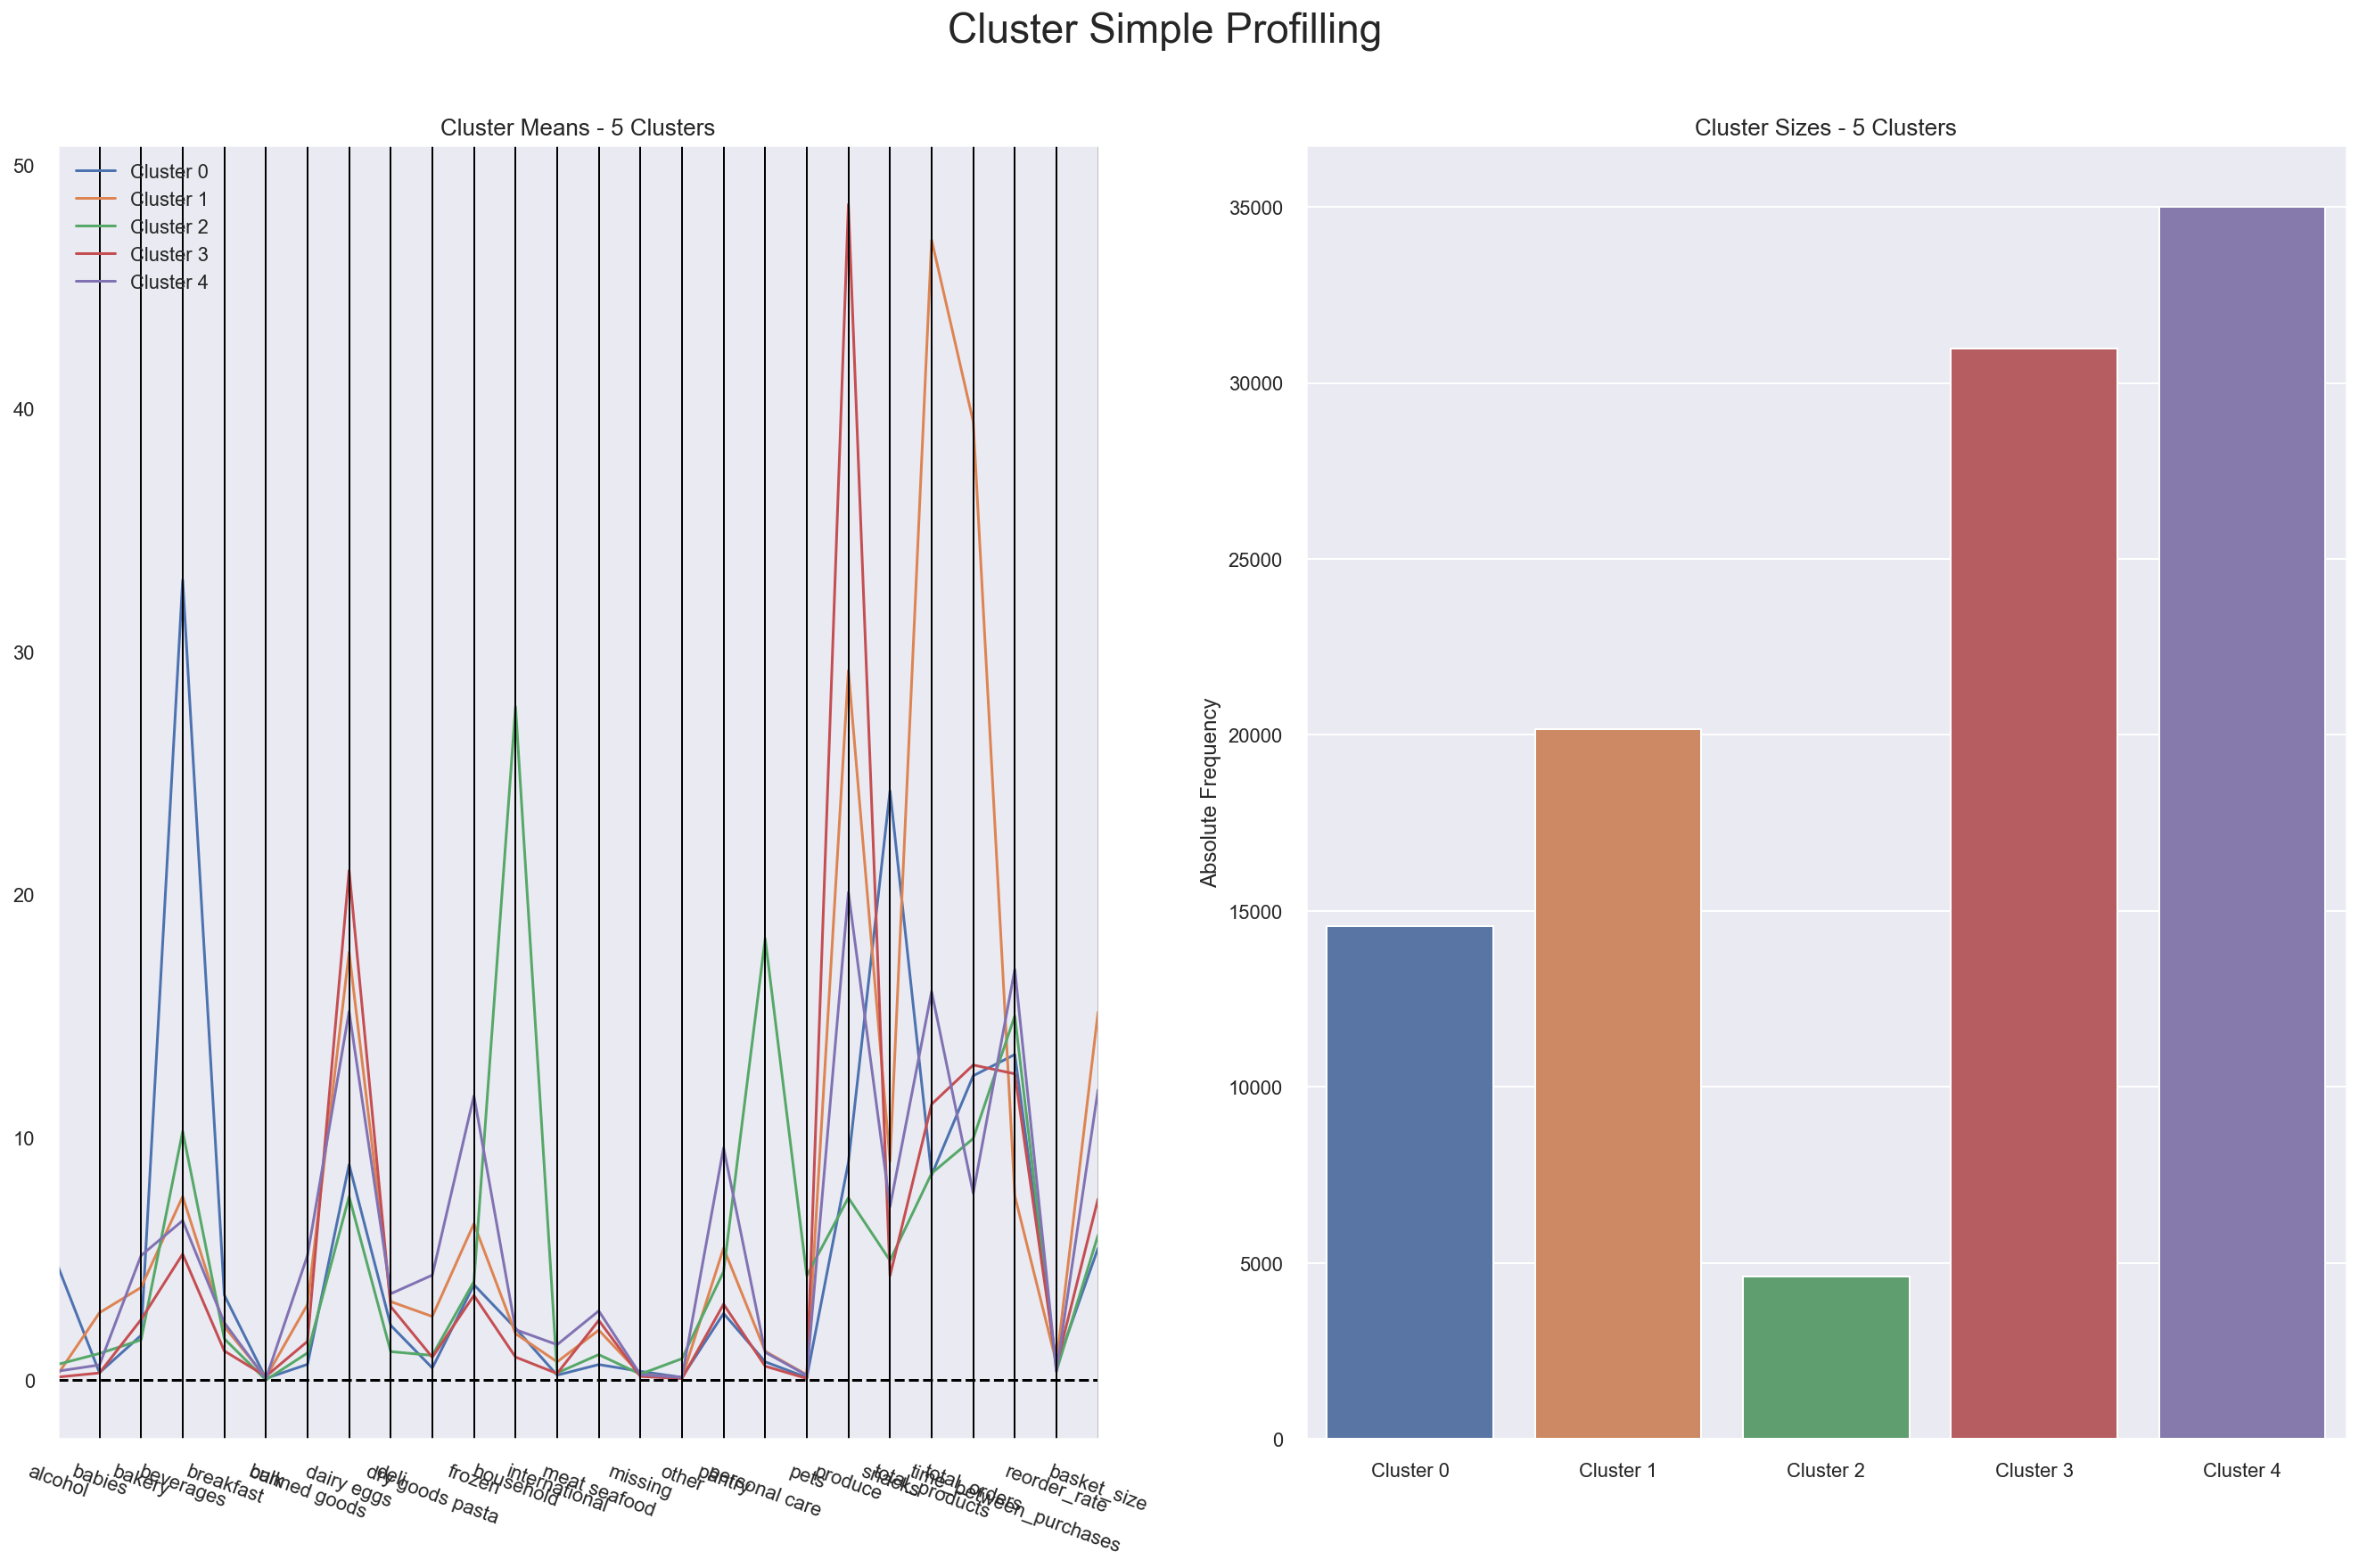

In [410]:
cluster_profiles(kmeans_data_clust_test, ["kmeans_labels"], figsize=(23, 13))

In [411]:

kmeans_summary = user_clustering_df_combined.copy()
kmeans_summary['kmeans_labels'] = kmeans_data_clust_test['kmeans_labels'].reset_index().set_index(user_clustering_df_combined.index).drop(columns='user_id')['kmeans_labels']

#calculate %of users, %of orders and %of products for each cluster
user_orders = kmeans_summary.groupby("kmeans_labels")['total_orders'].sum()
user_products = kmeans_summary.groupby("kmeans_labels")['total_products'].sum()
user_count = kmeans_summary.groupby("kmeans_labels")['total_orders'].count()

kmeans_summary = kmeans_summary.groupby("kmeans_labels").mean()

kmeans_summary['% of users'] = (user_count/user_count.sum())*100
kmeans_summary['`% of orders'] = (user_orders/user_orders.sum())*100
kmeans_summary['% of products'] = (user_products/user_products.sum())*100

round(kmeans_summary, 2).T

kmeans_labels               0      1      2      3      4
department                                               
alcohol                  4.70   0.25   0.66   0.13   0.38
babies                   0.31   2.78   1.10   0.30   0.63
bakery                   1.85   3.82   1.66   2.50   5.14
beverages               32.94   7.57  10.25   5.20   6.57
breakfast                3.51   2.21   1.71   1.21   2.38
bulk                     0.08   0.12   0.01   0.17   0.06
canned goods             0.66   3.12   1.13   1.60   5.14
dairy eggs               8.88  17.62   7.56  20.98  15.18
deli                     2.26   3.24   1.18   3.04   3.56
dry goods pasta          0.51   2.63   1.03   0.95   4.33
frozen                   3.93   6.45   4.06   3.50  11.71
household                2.14   1.92  27.73   0.96   2.09
international            0.21   0.76   0.30   0.28   1.47
meat seafood             0.65   2.07   1.06   2.47   2.86
missing                  0.37   0.26   0.25   0.16   0.23
other                    0.12   0.10   0.89   0.07   0.12
pantry                   2.75   5.44   4.47   3.13   9.57
personal care            0.76   1.19  18.18   0.58   1.16
pets                     0.12   0.23   4.31   0.08   0.21
produce                  8.97  29.21   7.51  48.40  20.08
snacks                  24.26   9.01   4.93   4.30   7.15
total_products           8.44  46.93   8.52  11.36  16.00
total_orders            12.53  39.45   9.95  12.98   7.70
time_between_purchases  13.41   7.59  15.00  12.61  16.91
reorder_rate             0.59   0.72   0.38   0.62   0.36
basket_size              5.44  15.15   5.97   7.47  11.95
% of users              13.82  19.14   4.37  29.42  33.24
`% of orders            10.76  46.91   2.70  23.72  15.91
% of products            6.08  46.82   1.94  17.43  27.73

Cluster 0: Dominant departments are Beverages, Snacks and Alcohol <break>
    
    14% of users
    10% of orders
    6% of products sold
    
    Low basket size
    Purchase every 2 weeks
    
Cluster 1: Mostly produce and dairy but highest babies <break>
    
    19% of users
    47% of orders
    46% of products sold
    
    High basket size
    High reorder rate
    Purchase weekly
    
    

## Adding cluster labels to original dataset

In [362]:
user_label = user_clustering_df_combined.copy()
user_label = kmeans_data_clust_test['kmeans_labels'].reset_index().set_index(user_clustering_df_combined.index).drop(columns='user_id')['kmeans_labels']
user_label.reset_index()
df_merged_clust = df_merged.merge(user_label.reset_index(), on='user_id', how='inner')
df_merged_clust

order_id  product_id  add_to_cart_order  reordered  user_id  \
0              10          24                  1          1   135442   
1              10          83                  2          1   135442   
2              10          16                  3          0   135442   
3              10          24                  4          1   135442   
4              10          83                  5          1   135442   
...           ...         ...                ...        ...      ...   
2019496   3420578          66                 17          0     6586   
2019497   3420578          16                 18          1     6586   
2019498   3420693          37                  1          0    68287   
2019499   3420693          37                  2          0    68287   
2019500   3420693          37                  3          0    68287   

         order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0                   4          6                  8                     8.0   
1                   4          6                  8                     8.0   
2                   4          6                  8                     8.0   
3                   4          6                  8                     8.0   
4                   4          6                  8                     8.0   
...               ...        ...                ...                     ...   
2019496             6          5                 21                     5.0   
2019497             6          5                 21                     5.0   
2019498            15          6                 15                     6.0   
2019499            15          6                 15                     6.0   
2019500            15          6                 15                     6.0   

         department_id      product_name     department  kmeans_labels  
0                    4      fresh fruits        produce              1  
1                    4  fresh vegetables        produce              1  
2                    4       fresh herbs        produce              1  
3                    4      fresh fruits        produce              1  
4                    4  fresh vegetables        produce              1  
...                ...               ...            ...            ...  
2019496              6       asian foods  international              4  
2019497              4       fresh herbs        produce              4  
2019498              1     ice cream ice         frozen              4  
2019499              1     ice cream ice         frozen              4  
2019500              1     ice cream ice         frozen              4  

[2019501 rows x 13 columns]

## Comparing Top35 products for each segment

In [403]:
print('Cluster 0 - Beverages, Snacks and Alcohol')
Top0 = df_merged_clust[df_merged_clust['kmeans_labels']==0]['product_name'].value_counts().reset_index().iloc[:35, :].rename(columns={'index': 'clust0-product', 'product_name': 'clust0-total_purchased'})

print('Cluster 1 - Mostly produce and dairy but highest babies')
Top1 = df_merged_clust[df_merged_clust['kmeans_labels']==1]['product_name'].value_counts().reset_index().iloc[:35, :].rename(columns={'index': 'clust1-product', 'product_name': 'clust1-total_purchased'})

print('Cluster 2 - Household, Personal Care and Pets')
Top2 = df_merged_clust[df_merged_clust['kmeans_labels']==2]['product_name'].value_counts().reset_index().iloc[:35, :].rename(columns={'index': 'clust1-product', 'product_name': 'clust2-total_purchased'})

print('Cluster 3 - Produce and dairy')
Top3 = df_merged_clust[df_merged_clust['kmeans_labels']==3]['product_name'].value_counts().reset_index().iloc[:35, :].rename(columns={'index': 'clust3-product', 'product_name': 'clust3-total_purchased'})

print('Cluster 4 - Highest Pantry, Frozen, Canned and bakery')
Top4 = df_merged_clust[df_merged_clust['kmeans_labels']==4]['product_name'].value_counts().reset_index().iloc[:35, :].rename(columns={'index': 'clust4-product', 'product_name': 'clust4-total_purchased'})


pd.concat([Top0, Top1, Top2, Top3, Top4], axis=1)

Cluster 0 - Beverages, Snacks and Alcohol
Cluster 1 - Mostly produce and dairy vut highest babies
Cluster 2 - Household, Personal Care and Pets
Cluster 3 - Produce and dairy
Cluster 4 - Highest Pantry, Frozen, Canned and bakery


clust0-product  clust0-total_purchased  \
0   water seltzer sparkling water                   12105   
1                    fresh fruits                    6665   
2                     soft drinks                    6572   
3                  chips pretzels                    6552   
4                    refrigerated                    5568   
5             energy granola bars                    5197   
6                 candy chocolate                    4282   
7                        crackers                    3686   
8                          yogurt                    3273   
9                             tea                    3218   
10                  juice nectars                    3045   
11                  cookies cakes                    2748   
12         nuts seeds dried fruit                    2722   
13                           milk                    2479   
14                         coffee                    2424   
15     packaged vegetables fruits                    2413   
16                         cereal                    2295   
17                  popcorn jerky                    2170   
18               fresh vegetables                    2050   
19                packaged cheese                    1941   
20                  ice cream ice                    1877   
21                soy lactosefree                    1770   
22                  beers coolers                    1767   
23           energy sports drinks                    1689   
24         fruit vegetable snacks                    1547   
25                          cream                    1445   
26           fresh dips tapenades                    1369   
27                    paper goods                    1246   
28                          bread                    1159   
29               packaged produce                    1088   
30                   frozen meals                     959   
31                      red wines                     950   
32                     lunch meat                     916   
33        breakfast bars pastries                     881   
34                        spreads                     863   

                   clust1-product  clust1-total_purchased  \
0                    fresh fruits                  111517   
1                fresh vegetables                  100918   
2      packaged vegetables fruits                   52510   
3                          yogurt                   47874   
4                 packaged cheese                   30223   
5                            milk                   27473   
6   water seltzer sparkling water                   21521   
7                  chips pretzels                   21365   
8                 soy lactosefree                   18942   
9               baby food formula                   18588   
10                          bread                   17946   
11                   refrigerated                   16789   
12            energy granola bars                   15070   
13                 frozen produce                   14982   
14                       crackers                   13889   
15                  ice cream ice                   12683   
16                           eggs                   12661   
17                     lunch meat                   12001   
18                         cereal                   11078   
19                    fresh herbs                   10997   
20           fresh dips tapenades                   10449   
21                   frozen meals                    9679   
22                          cream                    9337   
23            soup broth bouillon                    9221   
24                  juice nectars                    9208   
25         nuts seeds dried fruit                    9188   
26           other creams cheeses                    9065   
27             baking ingredients                    8915   
28                candy chocolate                    

## Comparing Purchasing Patterns for each segment

Cluster 0 - Beverages, Snacks and Alcohol


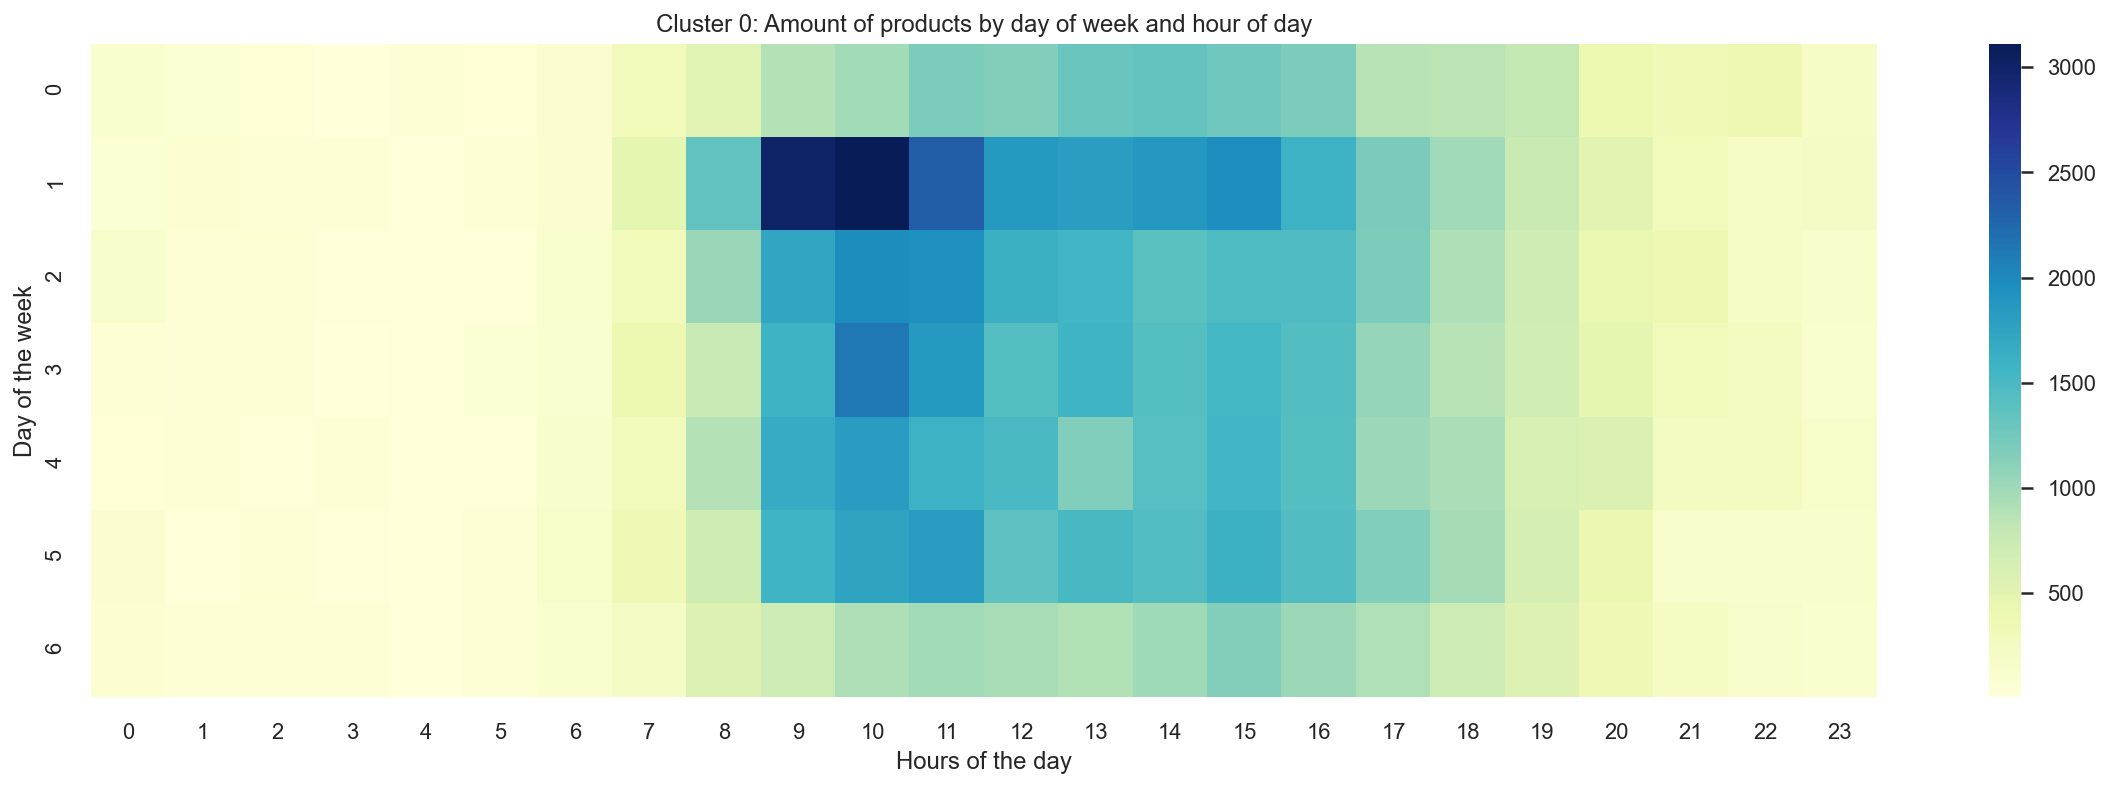

In [404]:
print('Cluster 0 - Beverages, Snacks and Alcohol')
    
df_merged_produce = df_merged_clust[df_merged_clust['kmeans_labels']==0]
grouped_df = df_merged_produce.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count")
grouped_df = pd.DataFrame(grouped_df).reset_index().pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Cluster 0: Amount of products by day of week and hour of day")
plt.xlabel('Hours of the day')
plt.ylabel('Day of the week')
plt.show()

Cluster 1 - Mostly produce and dairy vut highest babies


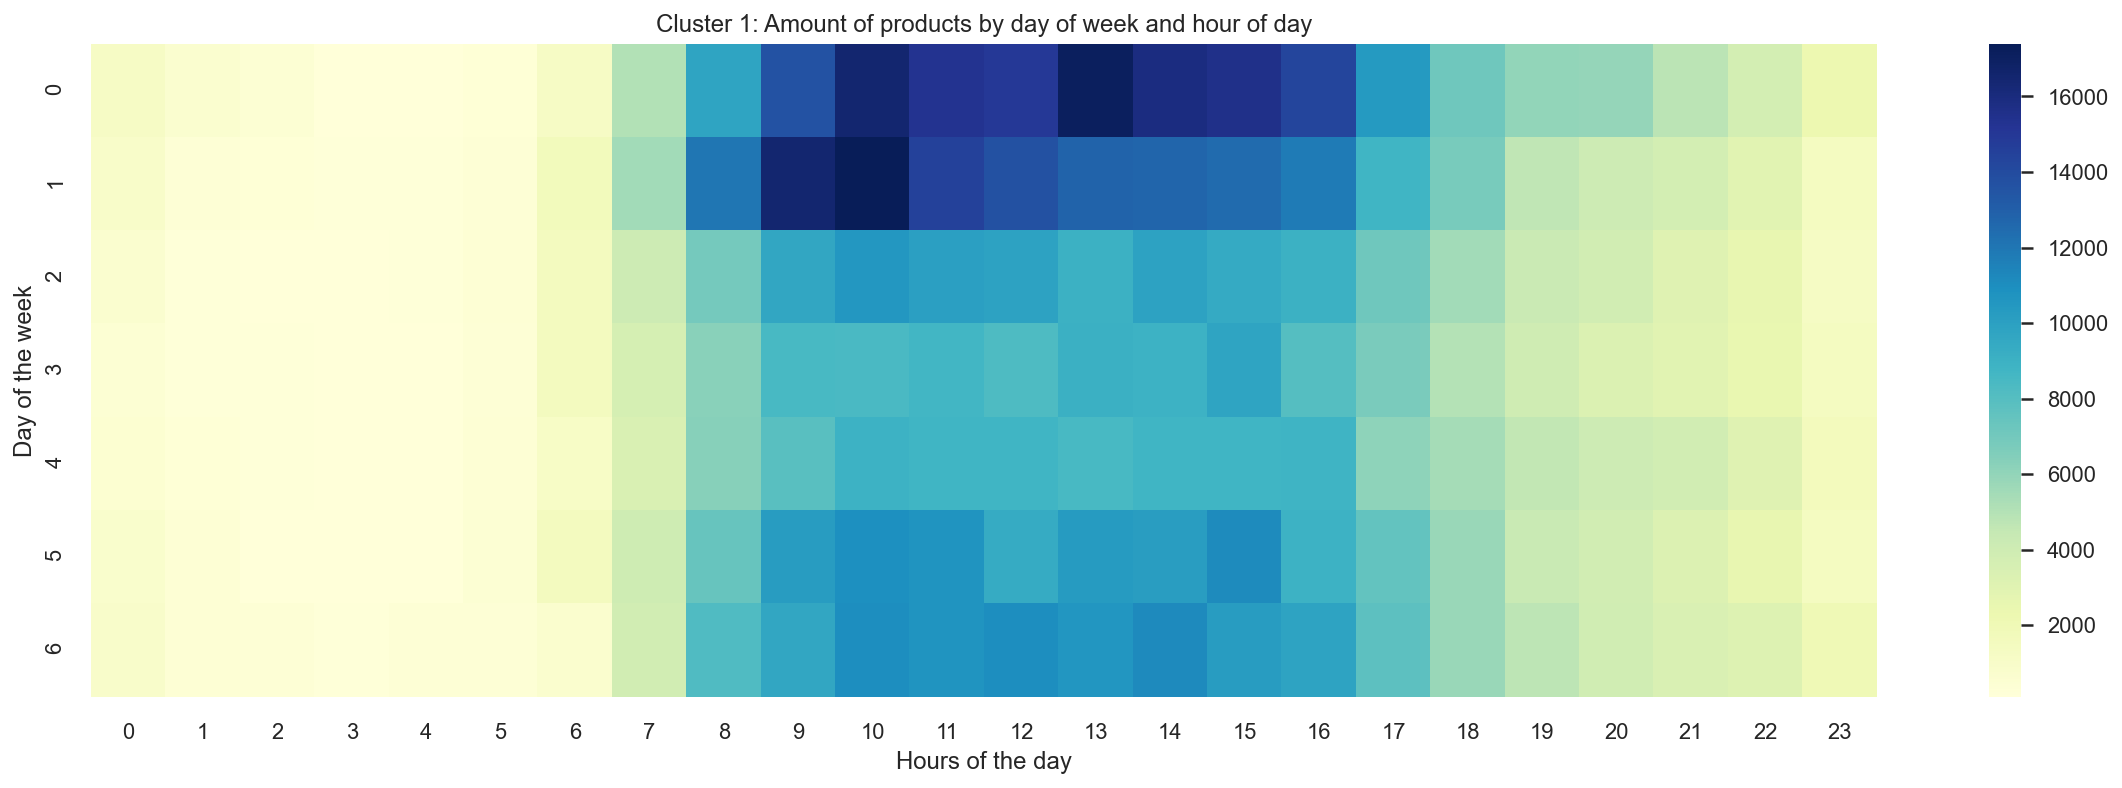

In [405]:
print('Cluster 1 - Mostly produce and dairy but highest babies')

df_merged_produce = df_merged_clust[df_merged_clust['kmeans_labels']==1]
grouped_df = df_merged_produce.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count")
grouped_df = pd.DataFrame(grouped_df).reset_index().pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Cluster 1: Amount of products by day of week and hour of day")
plt.xlabel('Hours of the day')
plt.ylabel('Day of the week')
plt.show()

Cluster 2 - Household, Personal Care and Pets


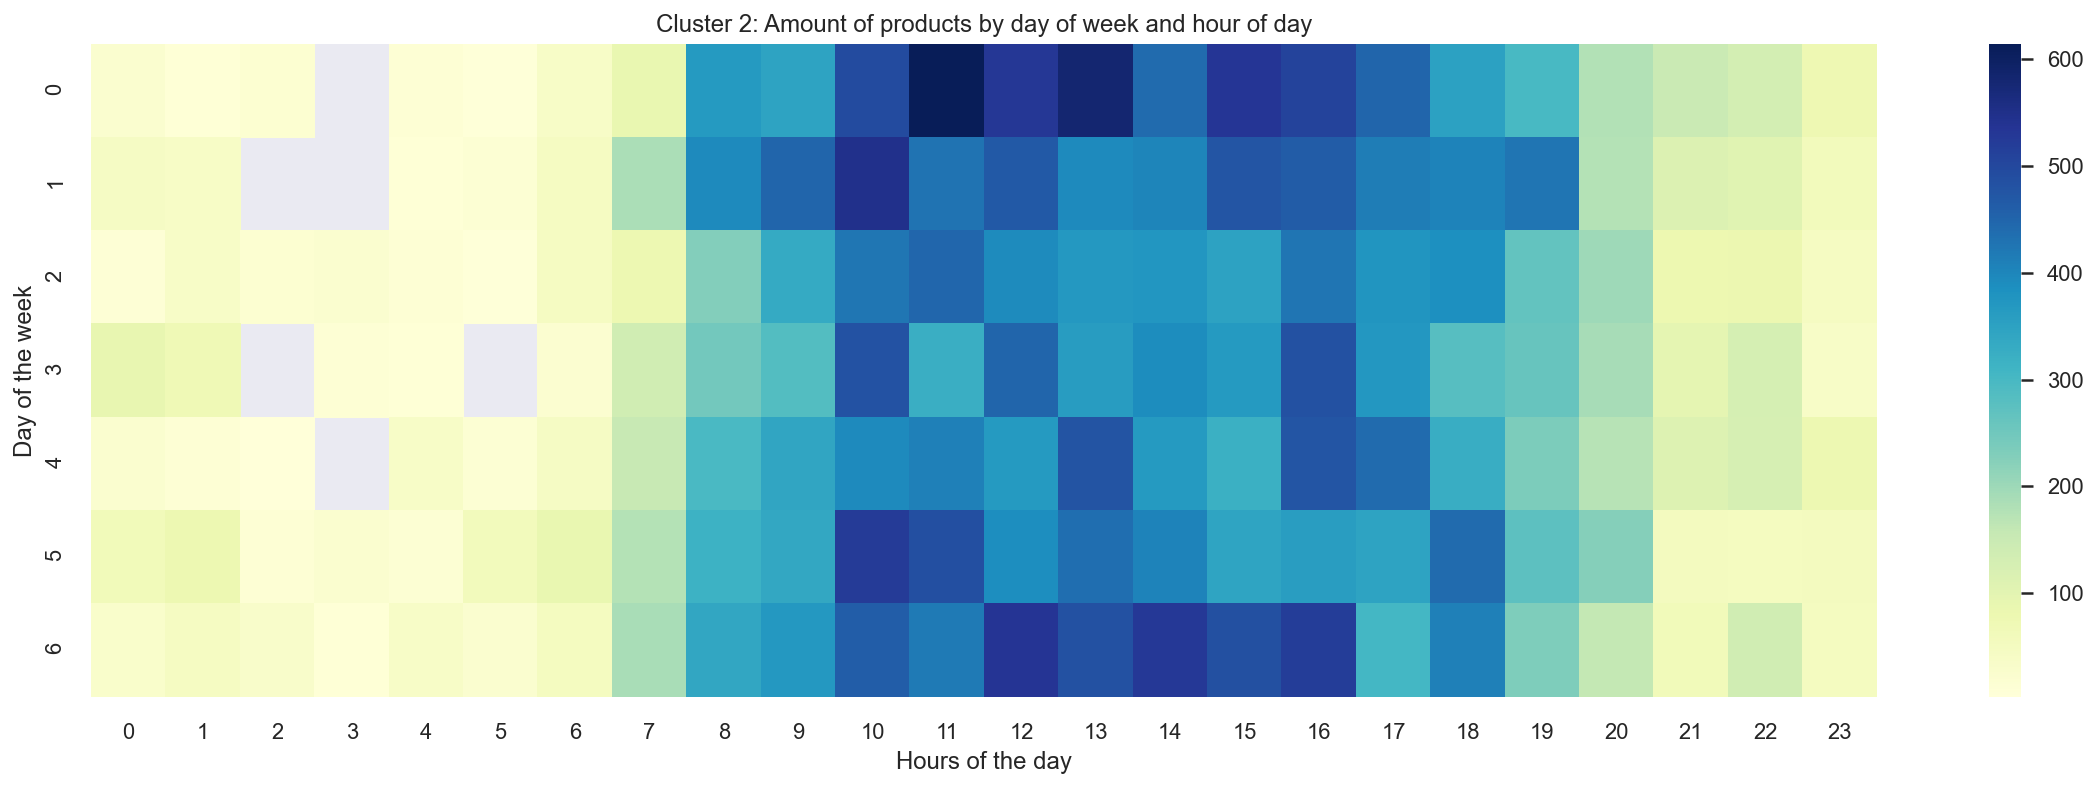

In [406]:
print('Cluster 2 - Household, Personal Care and Pets')

df_merged_produce = df_merged_clust[df_merged_clust['kmeans_labels']==2]
grouped_df = df_merged_produce.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count")
grouped_df = pd.DataFrame(grouped_df).reset_index().pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Cluster 2: Amount of products by day of week and hour of day")
plt.xlabel('Hours of the day')
plt.ylabel('Day of the week')
plt.show()

Cluster 3 - Produce and dairy


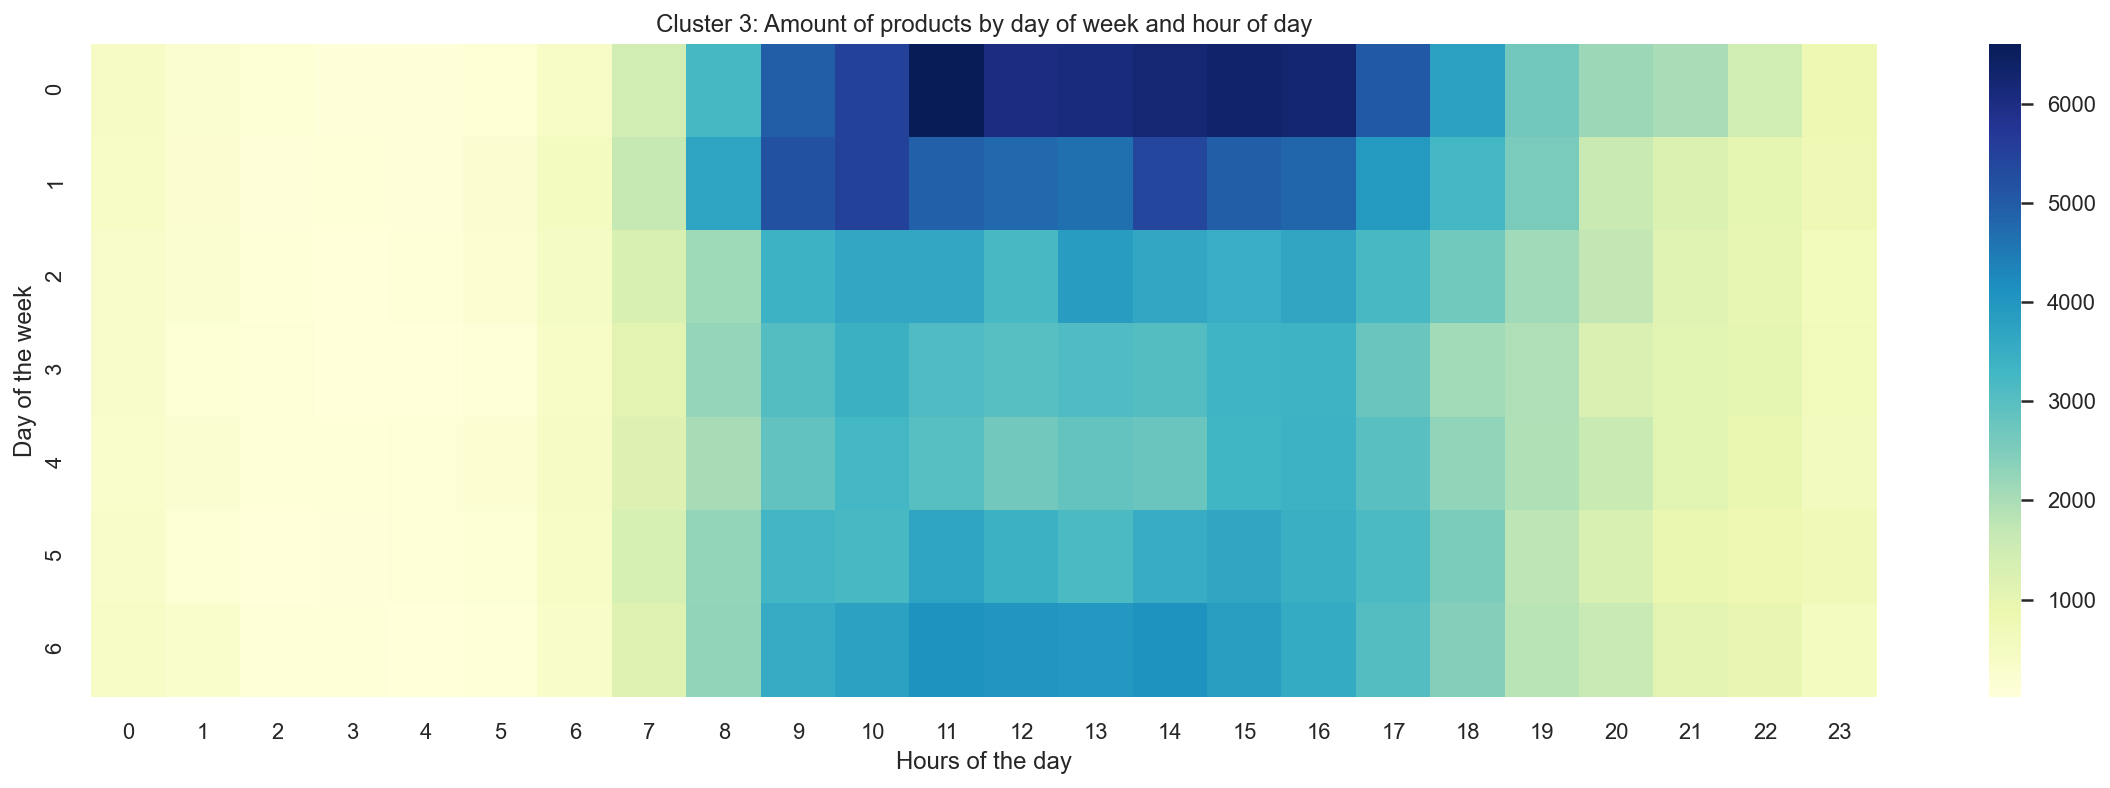

In [407]:
print('Cluster 3 - Produce and dairy')

df_merged_produce = df_merged_clust[df_merged_clust['kmeans_labels']==3]
grouped_df = df_merged_produce.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count")
grouped_df = pd.DataFrame(grouped_df).reset_index().pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Cluster 3: Amount of products by day of week and hour of day")
plt.xlabel('Hours of the day')
plt.ylabel('Day of the week')
plt.show()

Cluster 4 - Highest Pantry, Frozen, Canned and bakery


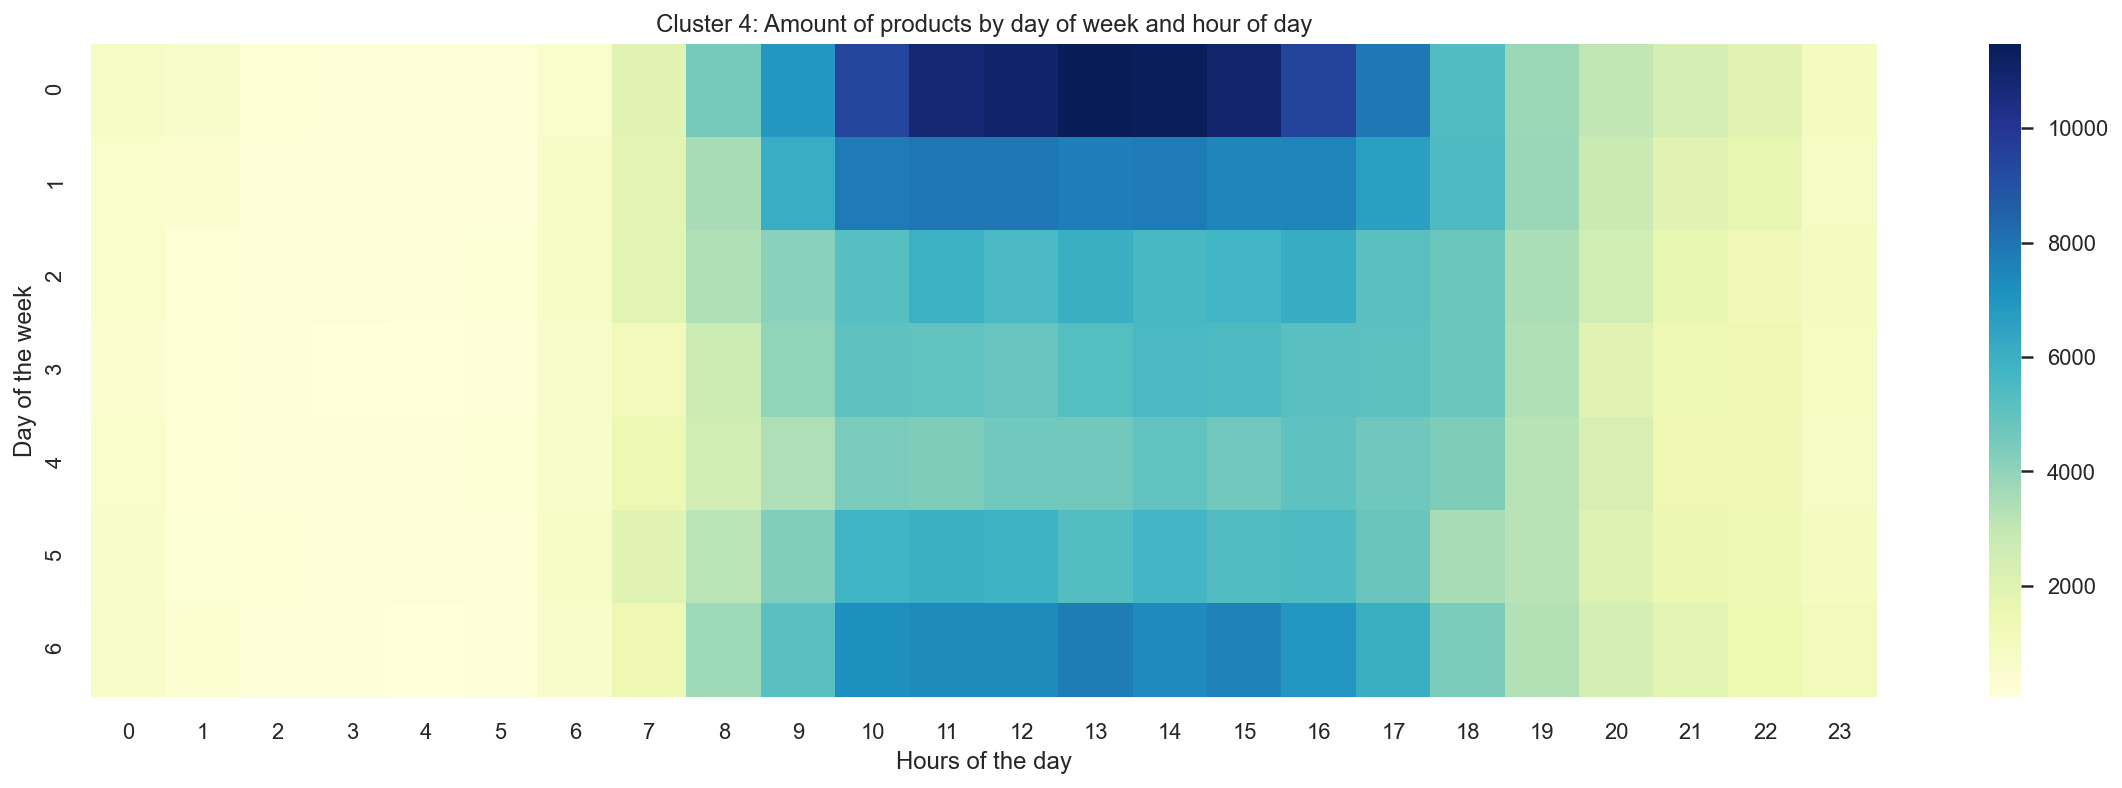

In [408]:
print('Cluster 4 - Highest Pantry, Frozen, Canned and bakery')

df_merged_produce = df_merged_clust[df_merged_clust['kmeans_labels']==4]
grouped_df = df_merged_produce.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count")
grouped_df = pd.DataFrame(grouped_df).reset_index().pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Cluster 4: Amount of products by day of week and hour of day")
plt.xlabel('Hours of the day')
plt.ylabel('Day of the week')
plt.show()